<a href="https://colab.research.google.com/github/asokraju/Power-Converters/blob/testing/DDPG/buck_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# PyPI packages
import matplotlib.pyplot as plt
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import argparse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, Sequential, layers
import datetime
from scipy.io import savemat
import os
from collections import deque
import random
 
import tensorflow as tf
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import argparse
from tensorflow import keras
from tensorflow.keras import Input, Model, Sequential, layers
import datetime
from scipy.io import savemat

#OU noise

In [ ]:
#OU Noise
# Taken from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py, which is
# based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.3, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)


#Buck

In [ ]:


class Buck_Converter_n(gym.Env):
    """
    Buck converter model following gym interface.
    We are assuming that the switching frequency is very High.
    Action space is continious and symmetric.
    Parameters need to satisfy: (1+RG)Vdes < Vs.
    It saves the input and state trajectories inside self.state_trajectory, self.action_trajectory.
    Has a plot method.

    env = Buck_Converter_n(Vs = 400, L = 1, C = 1, R =  1, G = .1, Vdes = 150, dt = 1e-2)
    env.reset()

    N_steps = 1000
    for i in range(N_steps):
        s2, r, terminal, info = env.step(env.action_des)
    env.plot()
    """
    metadata = {'render.modes': ['console']}

    def __init__(self, Vs = 400, L = 0.001, C = 0.001, R = 0.001, G = 0.04, Vdes = 220, dt = 1e-5):
        super(Buck_Converter_n, self).__init__()

        #parameters
        self.Vs = Vs
        self.L = L
        self.C = C
        self.R = R
        self.G = G

        #step size; since L and C are very low, the ode becomes stiff
        #For the default parameters the step size should in the order of 1e-5
        self.T = dt

        #the steady-state equilibrium of the system is
        self.Vdes = Vdes
        self.Ides = self.G * self.Vdes
        self.udes = (1/self.Vs) * (1 + self.G * self.R) * self.Vdes
        self.action_des = 2*self.udes - 1
        
        #The control action is duty-ratio which lies between 0 and 1 (We are assuming that the switching frequency is very High)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=np.array([-np.inf, -np.inf]), high=np.array([+np.inf, +np.inf]), shape=None, dtype=np.float32)
        
        self._get_state()

        #lists to save the states and actions 
        self.state_trajectory = []
        self.action_trajectory = []
        self.count_steps = 0 # counts the number of steps taken
    
    def _get_state(self):
        #initializing the state vector near to the desired values
        if self.udes >= 1:
            raise ValueError("for buck converter desired dutyratio should be less than 1 and greater than zero. Try: decreasing Vdes or increasing Vs.")
        I = np.random.uniform(low = self.Ides*0.8, high = self.Ides*1.2)
        V = np.random.uniform(low = self.Vdes*0.8, high = self.Vdes*1.2)
        self.state = np.array([I, V])

    def _set_state(self, I, V):
        #using this function we can change the state variable
        self.state = np.array([I, V])

    def desired(self):
        #Provides the steady-state variables
        return np.array([self.Ides, self.Vdes, self.udes])

    def reset(self):
        """
        Important: re-initializing the state vector near to the desired values
        :return: (np.array) 
        and restting the state_trajectory and action_trajectory buffers
        """
        #self.state = np.array(np.random.normal([self.Ides , self.Vdes], 5)).astype(np.float32)
        #reset
        self._get_state()

        self.state_trajectory = []
        self.action_trajectory = []
        self.count_steps = 0
        return self.state
    
    def step(self, action):
        #u = (action + 1)/2.0

        u = np.clip((action + 1)/2.0, 0, 1)

        i = self.state[0]
        v = self.state[1]

        didt = (-1.0/self.L)*(self.R*i + v - self.Vs*u)
        dvdt = (1.0/self.C)*(i - self.G*v)

        new_i = i + self.T * didt
        new_v = v + self.T * dvdt

        self.state = np.array([new_i, new_v]).astype(np.float32)

        # normalize the rewards
        reward = -((new_v-self.Vdes)/10)**2
        done = False

        self.state_trajectory.append(self.state)
        self.action_trajectory.append([action])
        
        self.count_steps += 1

        return self.state, reward, done, {}

    def render(self, mode='console'):
        # Prints the error between the desired values and their corresponding states
        ei = self.state[0] - self.Ides
        ev = self.state[1] - self.Vdes
        if mode != 'console':
            raise NotImplementedError()
        # agent is represented as a cross, rest as a dot
        print("I-Ides = {:.2f}, V-Vdes = {:.2f}".format(ei, ev))

    def close(self):
        pass
    
    def plot(self):
        title_nodes = ['Current', 'Voltage', 'action']
        test_steps = self.count_steps
        time = np.array(range(test_steps), dtype=np.float32)*self.T
        test_obs_reshape = np.concatenate(self.state_trajectory).reshape((test_steps ,self.observation_space.shape[0]))
        test_act_reshape = np.concatenate(self.action_trajectory).reshape((test_steps ,self.action_space.shape[0]))
        state_dim = self.observation_space.shape[0]
        act_dim = self.action_space.shape[0]
        total_dim = self.observation_space.shape[0] + self.action_space.shape[0]

        fig, ax = plt.subplots(nrows=1, ncols=total_dim, figsize = (24,4))
        for i in range(state_dim):
            ax[i].plot(time, test_obs_reshape[:, i], label=title_nodes[i])
            ax[i].plot(time, np.full(test_obs_reshape[:,i].shape[0], self.desired()[i]), marker = '.', label='desired')
            #ax[i].set_ylim(des[i]-50, des[i]+50)
            ax[i].set_title(title_nodes[i], fontsize=15)
            ax[i].set_xlabel('Time', fontsize=10)
            ax[i].set_label('Label via method')
            ax[i].legend()
        for i in range(state_dim, total_dim):
            ax[i].plot(time, test_act_reshape, label=title_nodes[i])
            ax[i].plot(time, np.full(test_act_reshape.shape[0], self.action_des), marker = '.', label='desired')
            ax[i].set_xlabel('Time', fontsize=10)
            ax[i].set_title(title_nodes[i], fontsize=15)
            ax[i].set_label('Label via method')
            ax[i].legend()
        plt.show()

In [ ]:
env = Buck_Converter_n()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high
args = {
    'summary_dir' : './results',
    'use_gpu': True,
    'buffer_size' : 1000000,
    'random_seed' : 1754,
    'max_episodes': 1,
    'max_episode_len' : 300,
    'mini_batch_size': 200,
    'actor_lr':0.0001,
    'critic_lr':0.001,
    'tau':0.001,
    'state_dim':state_dim,
    'action_dim':action_dim,
    'action_bound':action_bound,
    'gamma':0.999,
    'actor_l1':400,
    'actor_l2':300,
    'critic_l1':400,
    'critic_l2':300,
    'discretization_time': 1e-3,
    'noise_var':0.00925,
    'scaling': True,
    'save_model':True,
    'load_model':True,
    'time_steps':5
}
env.T

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


1e-05

Scale

In [ ]:
class Scaler(object):
    """ Generate scale and offset based on running mean and stddev along axis=0
        offset = running mean
        scale = 1 / (stddev + 0.1) / 3 (i.e. 3x stddev = +/- 1.0)
    """

    def __init__(self, obs_dim):
        """
        Args:
            obs_dim: dimension of axis=1
        """
        self.vars = np.zeros(obs_dim)
        self.means = np.zeros(obs_dim)
        self.m = 0
        self.n = 0
        self.first_pass = True

    def update(self, x):
        """ Update running mean and variance (this is an exact method)
        Args:
            x: NumPy array, shape = (N, obs_dim)
        see: https://stats.stackexchange.com/questions/43159/how-to-calculate-pooled-
               variance-of-two-groups-given-known-group-variances-mean
        """
        if self.first_pass:
            self.means = np.mean(x, axis=0)
            self.vars = np.var(x, axis=0)
            self.m = x.shape[0]
            self.first_pass = False
        else:
            n = x.shape[0]
            new_data_var = np.var(x, axis=0)
            new_data_mean = np.mean(x, axis=0)
            new_data_mean_sq = np.square(new_data_mean)
            new_means = ((self.means * self.m) + (new_data_mean * n)) / (self.m + n)
            self.vars = (((self.m * (self.vars + np.square(self.means))) +
                          (n * (new_data_var + new_data_mean_sq))) / (self.m + n) -
                         np.square(new_means))
            self.vars = np.maximum(0.0, self.vars)  # occasionally goes negative, clip
            self.means = new_means
            self.m += n

    def get(self):
        """ returns 2-tuple: (scale, offset) """
        return 1/(np.sqrt(self.vars) + 0.1)/3, self.means


def pprint_test(x):
    print(x)

#Replay Buffer

In [ ]:
# Replay buffer
# Taken from https://github.com/pemami4911/deep-rl/blob/master/ddpg/replay_buffer.py
class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

In [ ]:
test_env = Buck_Converter_n(Vs = 400, L = 1, C = 1, R = 1, G = 0.1, Vdes = 230, dt = 1e-3)
test_env.T

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.001

In [ ]:
env = Buck_Converter_n()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
s_0 = env.reset()
u_0 = 0.5
s_1, r_1, t_1, _ = env.step(u_0)
time_steps = 3
S_0 = []
U_0 =[]
S_1 = []
U_1 = []
for steps in range(time_steps):
    S_0.append(s_0)
    u_0 = np.random.normal(0, 0.001)
    U_0.append(u_0)
    s_1, r_1, t_1, _ = env.step(u_0)
    s_0 = s_1

_S_0 = np.concatenate(S_0).reshape(time_steps, state_dim)
print(_S_0, U_0)
print(np.shape(_S_0), np.shape(U_0))


[[ 10.02659347 206.88543236]
 [ 10.8881073  206.92974854]
 [ 10.81824493 206.95585632]] [-0.00019629356941152073, -0.0002282312628223462, 0.00010704824937185835]
(3, 2) (3,)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
s_0 = env.reset()
obs = []
actions = []
for steps in range(10):
    obs.append(s_0)
    u_0 = np.random.normal(0, 0.001)
    actions.append(u_0)
    s_1, r_1, t_1, _ = env.step(u_0)
    s_0 = s_1
print(obs)
print(actions)

[array([  9.38380332, 204.48990601]), array([  9.340089, 204.50195 ], dtype=float32), array([  9.295307, 204.51355 ], dtype=float32), array([  9.249327, 204.5247  ], dtype=float32), array([  9.201954, 204.53539 ], dtype=float32), array([  9.157062, 204.5456  ], dtype=float32), array([  9.108981, 204.55534 ], dtype=float32), array([  9.0618105, 204.5646   ], dtype=float32), array([  9.013222, 204.5734  ], dtype=float32), array([  8.965984, 204.5817  ], dtype=float32)]
[0.0006392446478391497, 0.00016573617310536732, -0.0003758711353437574, -0.001016466681573682, 0.0002769653696491722, -0.0012664176665181826, -0.0007631587220935181, -0.0014258627558489392, -0.0007066662601632727, -0.00042182003796156146]


In [ ]:
time_steps = 5
replay_buffer = ReplayBuffer(111111, 123)
# k = 1
# S_0 = obs[k: k + time_steps]
# #print(S_0)
# print(np.concatenate(S_0).reshape(time_steps, state_dim))
# S_1 = obs[k+1: k+1 + time_steps]
# #print(S_1)
# print(np.concatenate(S_1).reshape(time_steps, state_dim))

for k in range(10):
    obs.append(s_0)
    u_0 = np.random.normal(0, 0.001)
    actions.append(u_0)
    s_1, r_1, t_1, _ = env.step(u_0)
    s_0 = s_1
    S_0 = obs[k: k + time_steps]
    #print(S_0)
    #print(np.concatenate(S_0).reshape(time_steps, state_dim))
    S_1 = obs[k+1: k+1 + time_steps]
    #print(S_1)
    #print(np.concatenate(S_0).reshape(time_steps, state_dim),np.concatenate(S_1).reshape(time_steps, state_dim))
    replay_buffer.add(S_0, u_0, r_1, t_1, S_1)

In [ ]:
s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(6)
print(s_batch, a_batch, r_batch, t_batch, s2_batch)
print(np.shape(s_batch), np.shape(a_batch), np.shape(r_batch), np.shape(t_batch), np.shape(s2_batch))

# actor.predict(np.reshape(s,(1,actor.state_dim)))
# s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(args['mini_batch_size'])
# critic.predict_target(s2_batch, actor.predict_target(s2_batch))

# Actor Critic

In [ ]:
class ActorNetwork(object):
    def __init__(self, state_dim, action_dim, action_bound, learning_rate, tau, batch_size, params_l1, params_l2, time_steps):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau  = tau
        self.batch_size = batch_size
        self.params_l1 = params_l1
        self.params_l2 = params_l2
        self.time_steps = time_steps
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)

        #actor network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()
        self.actor_model = keras.Model(inputs=self.inputs, outputs=self.scaled_out, name='actor_network')
        self.network_params = self.actor_model.trainable_variables

        #target actor network
        self.target_inputs, self.target_out, self.target_scaled_out = self.create_actor_network()
        self.target_actor_model = keras.Model(inputs=self.target_inputs, outputs=self.target_scaled_out, name='target_actor_network')
        self.target_network_params = self.target_actor_model.trainable_variables

        #initalizing the target params with then network params
        for i in range(len(self.target_network_params)):
            self.target_network_params[i].assign(self.network_params[i])


    def create_actor_network(self):
        inputs = Input(shape = (self.time_steps, self.state_dim), batch_size = None, name = "actor_input_state")
        w_init = tf.random_uniform_initializer(minval=-0.03, maxval=0.03, seed=None)

        lstm_net = layers.LSTM(units= 100, return_sequences=False, return_state=False)(inputs)

        net = layers.Dense(self.params_l1, name = 'actor_dense_1', kernel_initializer = w_init)(lstm_net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation(activation=tf.nn.relu)(net)

        net = layers.Dense(self.params_l2, name = 'actor_dense_2', kernel_initializer = w_init)(net)
        net = layers.BatchNormalization()(net)
        net = layers.Activation(activation='tanh')(net)
        
        
        out = layers.Dense(self.action_dim, activation='tanh', name = 'actor_dense_3', kernel_initializer = w_init)(net)
        scaled_out = tf.multiply(out, self.action_bound, name = "actions_scaling")
        return inputs, out, scaled_out
  
    def update_target_network(self):
        self.update_target_network_params = [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) + tf.multiply(self.target_network_params[i], 1-self.tau)) for i in range(len(self.target_network_params))]
  
    def train(self, inputs, a_gradient):
        with tf.GradientTape(watch_accessed_variables=True) as tape:
            prediction = self.actor_model(inputs)
        unnormalized_actor_gradients = tape.gradient(prediction, self.network_params, output_gradients = -a_gradient)
        actor_gradients = list(map(lambda x: tf.math.divide(x, self.batch_size), unnormalized_actor_gradients))
        self.optimizer.apply_gradients(zip(actor_gradients, self.network_params))
    
    def predict(self, inputs):
        return self.actor_model(inputs)

    def predict_target(self, inputs):
        return self.target_actor_model(inputs)




In [ ]:
# s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(args['mini_batch_size'])
# critic.predict_target(s2_batch, actor.predict_target(s2_batch))
actor = ActorNetwork(
    state_dim = args['state_dim'],
    action_dim = args['action_dim'], 
    action_bound=args['action_bound'], 
    learning_rate = args['actor_lr'], 
    tau = args['tau'], 
    batch_size = args['mini_batch_size'],
    params_l1 = args['actor_l1'],
    params_l2 = args['actor_l2'],
    time_steps = args['time_steps']
    )
print('shape of s_batch', np.shape(s_batch))
print(actor.predict(s_batch))
print(actor.predict_target(s_batch))
actor.actor_model(s_batch)

shape of s_batch (0,)


IndexError: ignored

In [ ]:

class CriticNetwork(object):
    def __init__(self, state_dim, action_dim, action_bound, learning_rate, tau, gamma, params_l1, params_l2, time_steps):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_bound = action_bound
        self.learning_rate = learning_rate
        self.tau  = tau
        self.gamma = gamma
        self.params_l1 = params_l1
        self.params_l2 = params_l2
        self.time_steps = time_steps
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)

        #Critic Network and parameters
        self.inputs_state, self.inputs_action, self.out = self.create_critic_network()
        self.critic_model = keras.Model(inputs=[self.inputs_state, self.inputs_action], outputs=self.out, name='critic_network')
        self.network_params = self.critic_model.trainable_variables

        #Target Critic Network and parameters
        self.target_inputs_state, self.target_inputs_action, self.target_out = self.create_critic_network()
        self.target_critic_model = keras.Model(inputs=[self.target_inputs_state, self.target_inputs_action], outputs=self.target_out, name='target_critic_network')
        self.target_network_params = self.target_critic_model.trainable_variables
        
        #initalizing the target params with then network params
        for i in range(len(self.target_network_params)):
            self.target_network_params[i].assign(self.network_params[i])

        #gradients of Q function with respect to actions
    
    def create_critic_network(self):
        inputs_state = Input(shape = (self.time_steps, self.state_dim), batch_size = None, name = "critic_input_state")
        inputs_action = Input(shape = ( self.action_dim,), batch_size = None, name = "critic_input_action")
        w_init = tf.random_uniform_initializer(minval=-0.03, maxval=0.03, seed=None)

        #LSTM layer
        lstm_net = layers.LSTM(units = 100, return_sequences=False, return_state=False)(inputs_state)
        
        first hidden layer
        net_state = layers.Dense(self.params_l1, name = 'critic_dense_1', kernel_initializer = w_init)(lstm_net)
        net_state = layers.BatchNormalization()(net_state)
        net_state = layers.Activation(activation=tf.nn.relu)(net_state)

        # second hidden layer
        net_state = layers.Dense(self.params_l2, name = 'critic_dense_2_state', kernel_initializer = w_init)(net_state)
        net_action = layers.Dense(self.params_l2, name = 'critic_dense_2_action', kernel_initializer = w_init)(inputs_action)
        net = layers.Add()([net_state, net_action])
        net = layers.BatchNormalization()(net)
        net = layers.Activation(activation=tf.nn.relu)(net)

        #w_init = tf.random_uniform_initializer(minval=-0.03, maxval=0.03, seed=None)
        out = layers.Dense(1, name = 'Q_val', kernel_initializer = w_init)(net)
        return inputs_state, inputs_action, out

    def update_target_network(self):
        self.update_target_network_params = [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) + tf.multiply(self.target_network_params[i], 1-self.tau)) for i in range(len(self.target_network_params))]

    def train(self, input_state, input_actions, predicted_q_val):
        with tf.GradientTape(watch_accessed_variables=True) as tape:
            prediction = self.critic_model([input_state, input_actions])
            #print('predicted_q_val', np.shape(predicted_q_val))
            #print('prediction', np.shape(prediction))
            loss = tf.keras.losses.MSE(prediction, predicted_q_val)
        gradients = tape.gradient(loss, self.network_params)
        self.optimizer.apply_gradients(zip(gradients, self.network_params))
        return self.critic_model([input_state, input_actions])
  
    def action_gradient(self, input_state, input_actions):
        var = tf.constant(input_actions)
        with tf.GradientTape(watch_accessed_variables=False) as tape_a:
            tape_a.watch(var)
            prediction_a = self.critic_model([input_state, var])
        return tape_a.gradient(prediction_a, var)
  
    def predict(self, inputs_state, inputs_actions):
        return self.critic_model([inputs_state, inputs_actions])
  
    def predict_target(self, inputs_state, inputs_actions):
        return self.target_critic_model([inputs_state, inputs_actions])


In [ ]:
critic = CriticNetwork(
    state_dim = args['state_dim'], 
    action_dim = args['action_dim'], 
    action_bound = args['action_bound'], 
    learning_rate = args['critic_lr'], 
    tau = args['tau'], 
    gamma = args['gamma'],
    params_l1 = args['critic_l1'],
    params_l2 = args['critic_l2'],
    time_steps = args['time_steps']
    )
print('shape of s_batch', np.shape(s_batch))
actor_target_predition = actor.predict_target(s2_batch)
print('shape of actor target predition', np.shape(actor_predition))
target_q = np.array(critic.predict_target(s2_batch, actor_target_predition))
print('shape of critic predition', np.shape(target_q))

# print(actor.predict_target(s_batch))
# actor.actor_model(s_batch)
print(t_batch)
print('t_batch shape', np.shape(t_batch))
y = []
for k in range(6):
    if t_batch[k]:
        y.append(r_batch[k])
    else:
        y.append(r_batch[k] + critic.gamma * np.array(target_q[k]))

temp = np.reshape(y, (6, 1))
print('a_batch', np.shape(a_batch))

predicted_q_value = critic.train(s_batch, a_batch, temp.astype('float32'))

shape of s_batch (0,)


IndexError: ignored

In [ ]:
a_outs = actor.predict(s_batch)
print(a_outs)
grads = critic.action_gradient(s_batch, a_outs)

actor.train(s_batch, grads)
actor.update_target_network()
critic.update_target_network()

tf.Tensor(
[[-0.00230531]
 [-0.0023042 ]
 [-0.00230568]
 [-0.00230459]
 [-0.00230214]
 [-0.00230254]], shape=(6, 1), dtype=float32)


#Args

In [ ]:
env = Buck_Converter_n()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high
args = {
    'summary_dir' : './results',
    'use_gpu': True,
    'buffer_size' : 1000000,
    'random_seed' : 1754,
    'max_episodes': 1000,
    'max_episode_len' : 600,
    'mini_batch_size': 200,
    'actor_lr':0.0001,
    'critic_lr':0.001,
    'tau':0.001,
    'state_dim':state_dim,
    'action_dim':action_dim,
    'action_bound':action_bound,
    'gamma':0.999,
    'actor_l1':200,
    'actor_l2':100,
    'critic_l1':200,
    'critic_l2':100,
    'discretization_time': 1e-3,
    'noise_var':0.0925,
    'scaling': True,
    'save_model':True,
    'load_model':True,
    'time_steps':5
}

actor = ActorNetwork(
    state_dim = args['state_dim'],
    action_dim = args['action_dim'], 
    action_bound=args['action_bound'], 
    learning_rate = args['actor_lr'], 
    tau = args['tau'], 
    batch_size = args['mini_batch_size'],
    params_l1 = args['actor_l1'],
    params_l2 = args['actor_l2'],
    time_steps = args['time_steps']
    )
critic = CriticNetwork(
    state_dim = args['state_dim'], 
    action_dim = args['action_dim'], 
    action_bound = args['action_bound'], 
    learning_rate = args['critic_lr'], 
    tau = args['tau'], 
    gamma = args['gamma'],
    params_l1 = args['critic_l1'],
    params_l2 = args['critic_l2'],
    time_steps = args['time_steps']
    )

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
s_0 = env.reset()
obs = []
actions = []
for steps in range(10):
    obs.append(s_0)
    u_0 = np.random.normal(0, 0.001)
    actions.append(u_0)
    s_1, r_1, t_1, _ = env.step(u_0)
    s_0 = s_1
print(obs)
print(actions)
for k in range(1):
    obs.append(s_0)
    u_0 = np.random.normal(0, 0.001)
    actions.append(u_0)
    s_1, r_1, t_1, _ = env.step(u_0)
    s_0 = s_1
    S_0 = obs[k: k + time_steps]
    S_0 = np.concatenate(S_0).reshape(1, time_steps, state_dim)
    print(S_0)
    print(S_1)
    #print(actor.predict(S_0))
    #print(S_0)
    #print(np.concatenate(S_0).reshape(time_steps, state_dim))
    S_1 = obs[k+1: k+1 + time_steps]
    S_1 = np.concatenate(S_1).reshape(time_steps, state_dim)
    print(np.shape(S_1))
    #print(S_1)
    #print(np.concatenate(S_0).reshape(time_steps, state_dim),np.concatenate(S_1).reshape(time_steps, state_dim))
    replay_buffer.add(S_0, u_0, r_1, t_1, S_1)

# actor.predict(np.reshape(s,(1,actor.state_dim)))
# s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(args['mini_batch_size'])
# critic.predict_target(s2_batch, actor.predict_target(s2_batch))

In [ ]:
s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(3)
print(s_batch)
print(np.shape(s_batch))

In [ ]:
s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(3)
print(np.shape(s_batch))

(0,)


In [ ]:
print(actor.predict(s_batch))
print(actor.predict_target(s_batch))
print(critic.predict(s_batch, actor.predict_target(s_batch)))
print(critic.predict_target(s_batch, actor.predict_target(s_batch)))

InvalidArgumentError: ignored

In [ ]:
critic.predict(s_batch, a_batch)

InvalidArgumentError: ignored

In [ ]:
critic.predict_target(s2_batch, actor.predict_target(s2_batch))

InvalidArgumentError: ignored

#Train

In [ ]:
def train(env, test_env, args, actor, critic, actor_noise, reward_result, scaler, replay_buffer):
    writer = tf.summary.create_file_writer(logdir = args['summary_dir'])
    actor.update_target_network()
    critic.update_target_network()
    time_steps = args['time_steps']


    paths = list()

    for i in range(args['max_episodes']):
        test_env.reset()
        s = env.reset()
        ep_reward = 0
        ep_ave_max_q = 0
        obs, obs_scaled, actions, rewards = [], [], [], []
        if args['scaling']:
            var, mean = scaler.get()
        else:
            var, mean = 1.0, 0.0
        # if i<10:
        #     temp_a = np.random.normal(0, 0.01)
        for _ in range(time_steps-1):
            s_scaled = np.float32((s - mean) * var)
            obs_scaled.append(s_scaled)
            obs.append(s)
            s, r, terminal, info = env.step(np.array([env.action_des], dtype="float32"))
            actions.append([env.action_des])

        s_scaled = np.float32((s - mean) * var)
        obs_scaled.append(s_scaled)
        obs.append(s)   
        actions.append([env.action_des])
        for j in range(args['max_episode_len']):

            
            S_0 = obs_scaled[-time_steps: ]
            
            #noise annealing
            noise = np.random.normal(0, args['noise_var']/((j/100)+1))
            a = actor.predict(np.reshape(S_0, (1, time_steps, state_dim))) + noise

            # action should be inbetween -1 and 1
            a = np.clip(a, -args['action_bound'], args['action_bound'])

            s2, r, terminal, info = env.step(a[0])
            s2_scaled = np.float32((s2 - mean) * var)

            #noise annealing
            obs_scaled.append(s2_scaled)
            S_2 = obs_scaled[-time_steps: ]

            replay_buffer.add(S_0, np.reshape(a, (actor.action_dim,)), r, terminal, S_2)
            if replay_buffer.size() > args['mini_batch_size']:
                s_batch, a_batch, r_batch, t_batch, s2_batch = replay_buffer.sample_batch(args['mini_batch_size'])

                target_q = np.array(critic.predict_target(s2_batch, actor.predict_target(s2_batch)))
                y = []
                for k in range(args['mini_batch_size']):
                    if t_batch[k]:
                        y.append(r_batch[k])
                    else:
                        y.append(r_batch[k] + critic.gamma * np.array(target_q[k]))

                temp = np.reshape(y, (args['mini_batch_size'], 1))

                predicted_q_value = critic.train(s_batch, a_batch, temp.astype('float32'))

                ep_ave_max_q += np.amax(predicted_q_value)

                a_outs = actor.predict(s_batch)
                grads = critic.action_gradient(s_batch, a_outs)
                
                actor.train(s_batch, grads)
                actor.update_target_network()
                critic.update_target_network()

            s = s2
            ep_reward += r
            obs.append(s)
            actions.append(a[0])
            rewards.append(r)

            if j+1 == args['max_episode_len']:
                with writer.as_default():
                    tf.summary.scalar("Reward", ep_reward, step = i)
                    tf.summary.scalar("Qmax Value", ep_ave_max_q / float(j), step = i)
                    writer.flush()
                print('| Reward: {:.4f} | Episode: {:d} | Qmax: {:.4f}'.format((ep_reward), i, (ep_ave_max_q / float(j))))
                reward_result[i] = ep_reward
                path = {
                    "Observation":np.concatenate(obs).reshape((args['max_episode_len']+args['time_steps'],2)), 
                    "Action":np.concatenate(actions), 
                    "Reward":np.asarray(rewards)
                    }
                paths.append(path)
                env.plot()
                #test_s = test_env.reset()
                # if i+1 == args['max_episodes']:
                #     env.plot()
                #     test_s = test_env.reset()
                #     for _ in range(1000):
                #         test_s_scaled = np.float32((test_s - mean) * var) 
                #         test_a = actor.predict(np.reshape(test_s_scaled,(1,actor.state_dim)))
                #         test_s, r, terminal, info = test_env.step(test_a[0])
                #     test_env.plot()
                break
    return [paths, reward_result] 

##testing

In [ ]:
obs_scaled =[]
s = env.reset()
mean, var = 0, 1
for i in range(time_steps-1):
    s_scaled = np.float32((s - mean) * var)
    obs_scaled.append(s_scaled)
    s, r, terminal, info = env.step(env.action_des)
    #print(obs_scaled)
s_scaled = np.float32((s - mean) * var)
obs_scaled.append(s_scaled)
#print(obs_scaled)
S_0 = obs_scaled[-time_steps: ]
print(S_0)
S_0 = np.reshape(S_0, (1, time_steps, state_dim))
print(S_0)
actor.predict(S_0)

[array([ 10.513964, 182.62413 ], dtype=float32), array([ 10.887705, 182.65622 ], dtype=float32), array([ 11.261122, 182.69203 ], dtype=float32), array([ 11.634177, 182.73157 ], dtype=float32), array([ 12.006833, 182.77481 ], dtype=float32)]
[[[ 10.513964 182.62413 ]
  [ 10.887705 182.65622 ]
  [ 11.261122 182.69203 ]
  [ 11.634177 182.73157 ]
  [ 12.006833 182.77481 ]]]


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9999859]], dtype=float32)>

#run

In [ ]:
test_env = Buck_Converter_n(Vs = 400, L = 1, C = 1, R = 1, G = 0.1, Vdes = 230, dt = args['discretization_time'])
env = Buck_Converter_n(Vs = 400, L = 1, C = 1, R = 1, G = 0.1, Vdes = 230, dt = args['discretization_time'])

test_s = test_env.reset()
test_obs=[]
test_steps = int(1/args['discretization_time'])
test_episodes = 2000
for _ in range(test_episodes):
    u = np.random.uniform(-1,1)
    for _ in range(test_steps):
        s, _,_,_ = test_env.step(u)
        test_obs.append(s)
scaler = Scaler(2)
scaler.update(np.concatenate(test_obs).reshape((test_steps*test_episodes,env.observation_space.shape[0])))
var, mean = scaler.get()
print(var, mean)
env.T

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[0.00515573 0.00472946] [ 17.829758 179.17798 ]


0.001

| Reward: -70722.2619 | Episode: 0 | Qmax: -1.7555


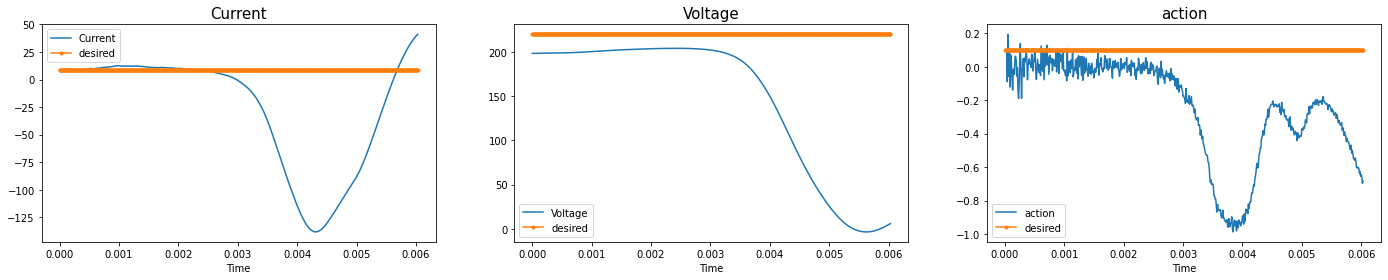

| Reward: -435697.2518 | Episode: 1 | Qmax: -2.4281


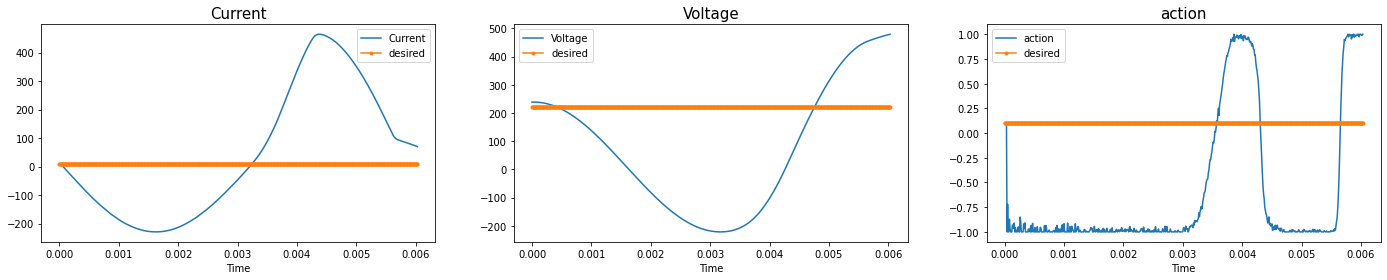

| Reward: -286449.7666 | Episode: 2 | Qmax: -1.1534


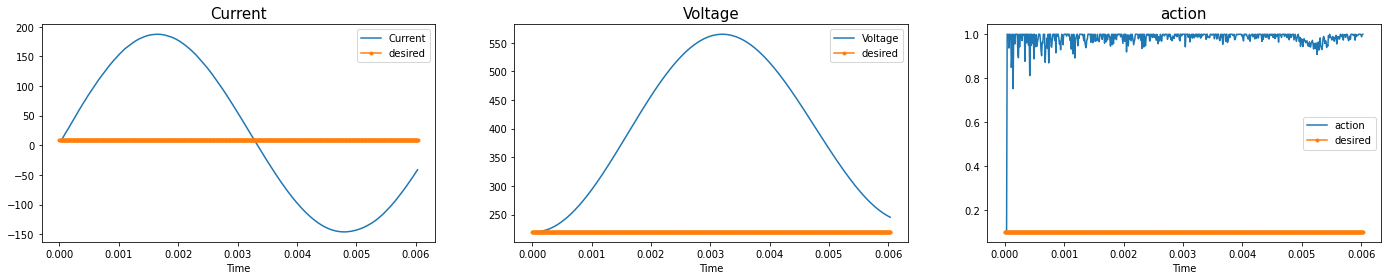

| Reward: -256906.3737 | Episode: 3 | Qmax: -17.0162


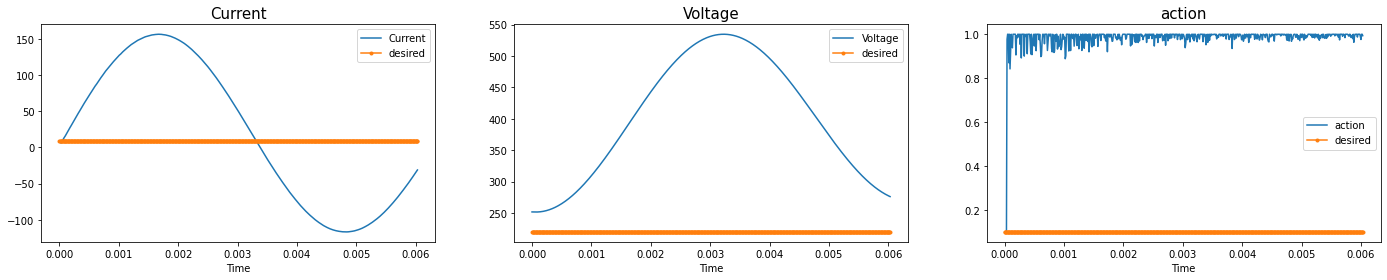

| Reward: -290124.1068 | Episode: 4 | Qmax: -13.4714


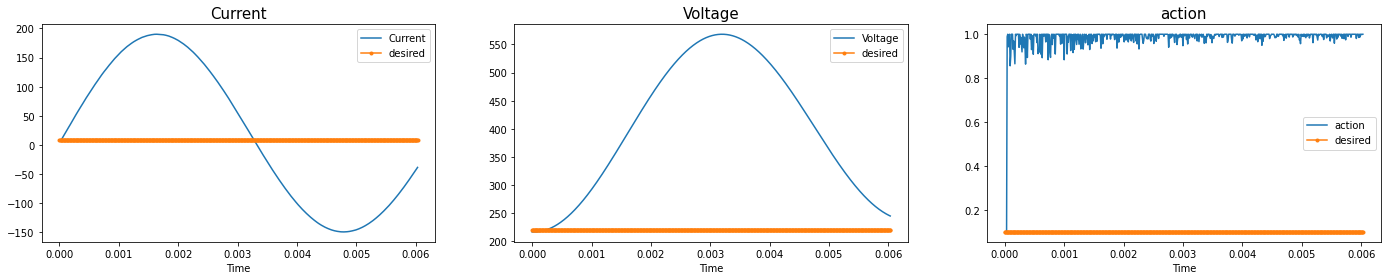

| Reward: -301089.5432 | Episode: 5 | Qmax: -10.3175


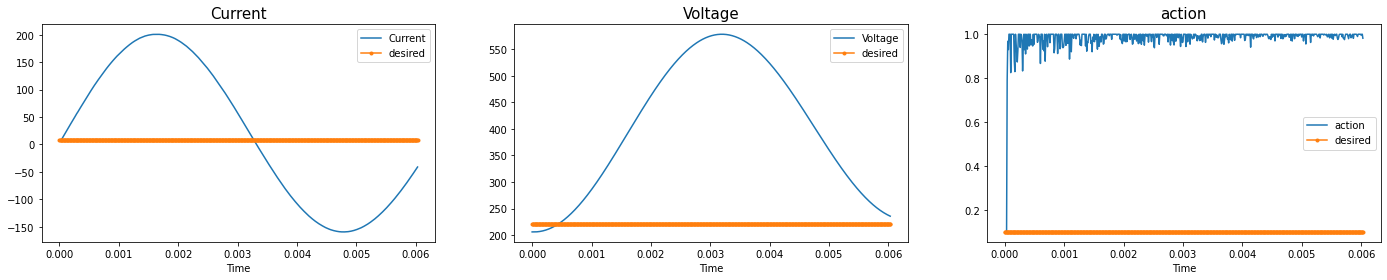

| Reward: -324641.4704 | Episode: 6 | Qmax: -9.7447


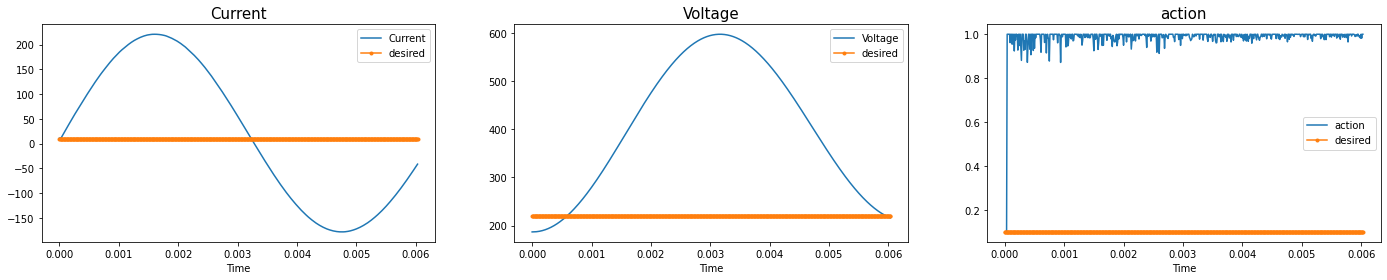

| Reward: -335402.5007 | Episode: 7 | Qmax: -5.6798


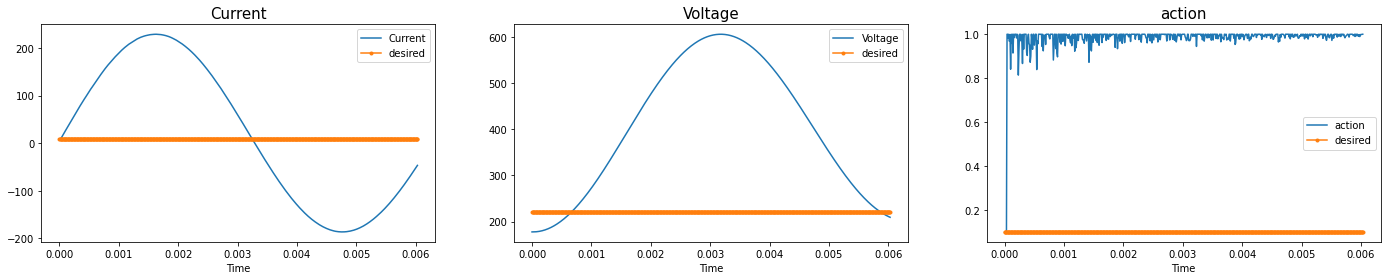

| Reward: -330305.1394 | Episode: 8 | Qmax: -3.5621


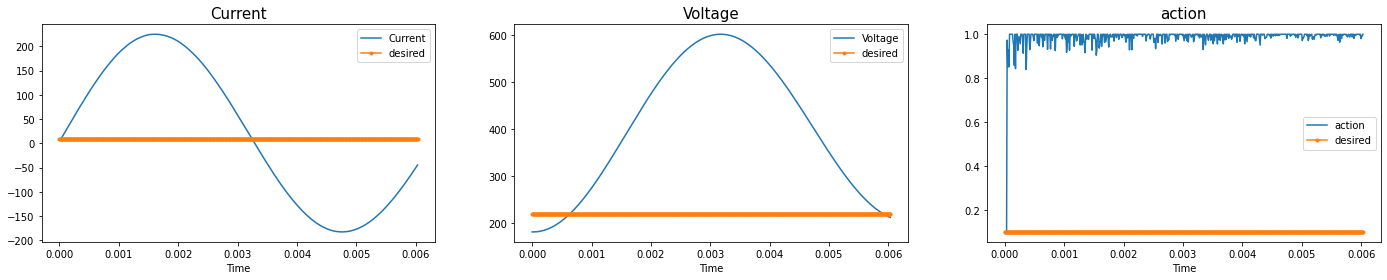

| Reward: -289526.1952 | Episode: 9 | Qmax: -2.4979


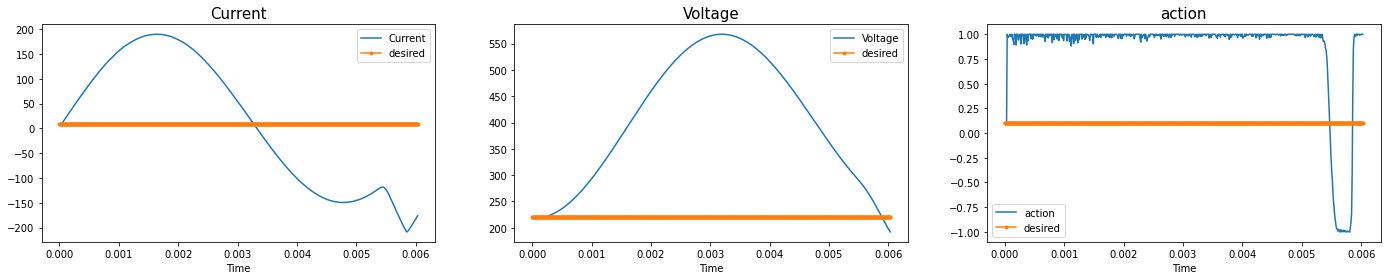

| Reward: -11574.6071 | Episode: 10 | Qmax: 3.8748


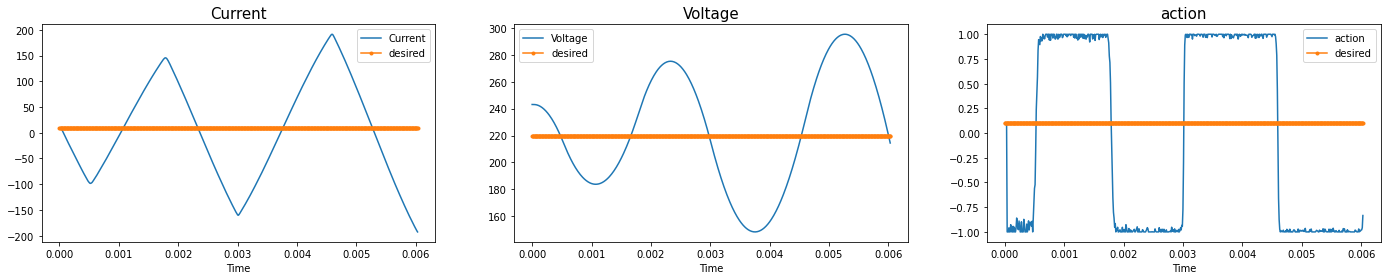

| Reward: -3042.2616 | Episode: 11 | Qmax: 7.5960


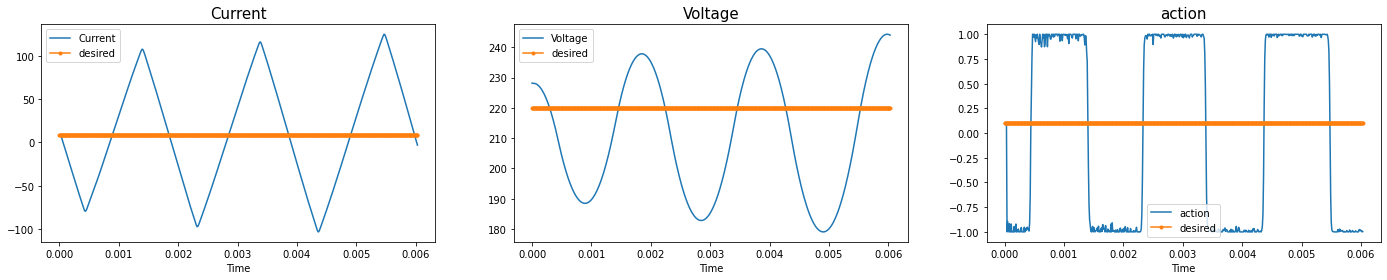

| Reward: -1664.7696 | Episode: 12 | Qmax: 8.9979


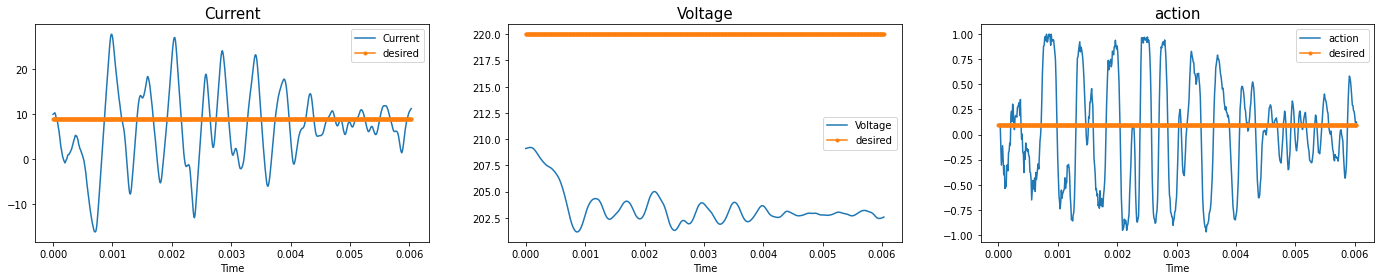

| Reward: -1908.4851 | Episode: 13 | Qmax: 9.3406


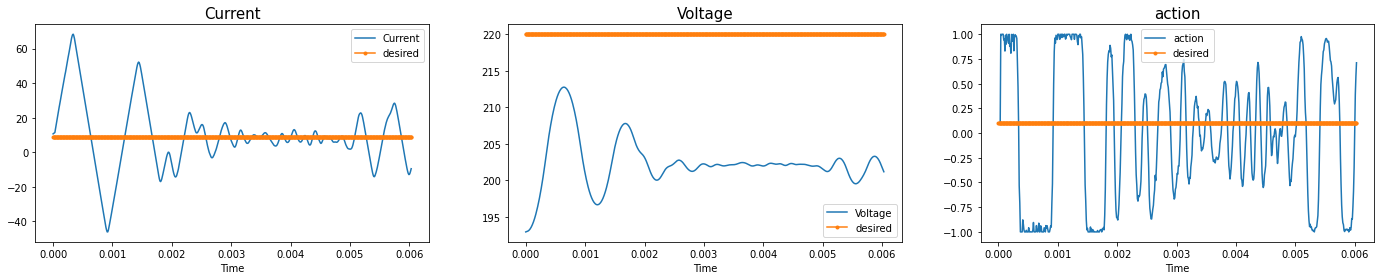

| Reward: -7380.0301 | Episode: 14 | Qmax: 9.3827


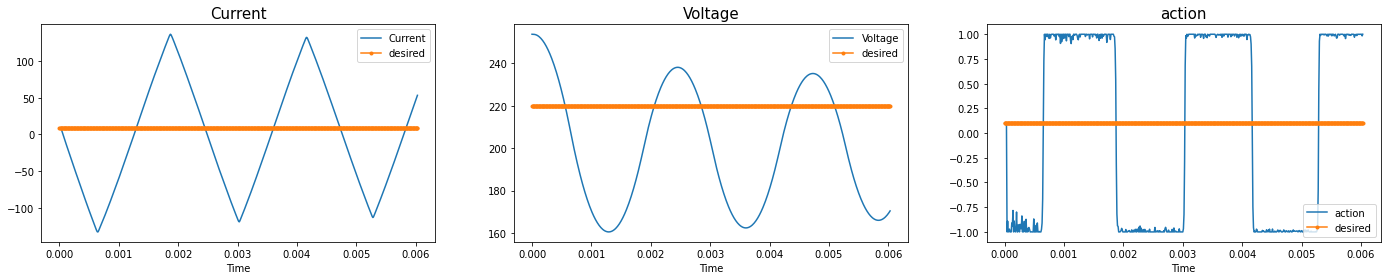

| Reward: -2411.7103 | Episode: 15 | Qmax: 10.0999


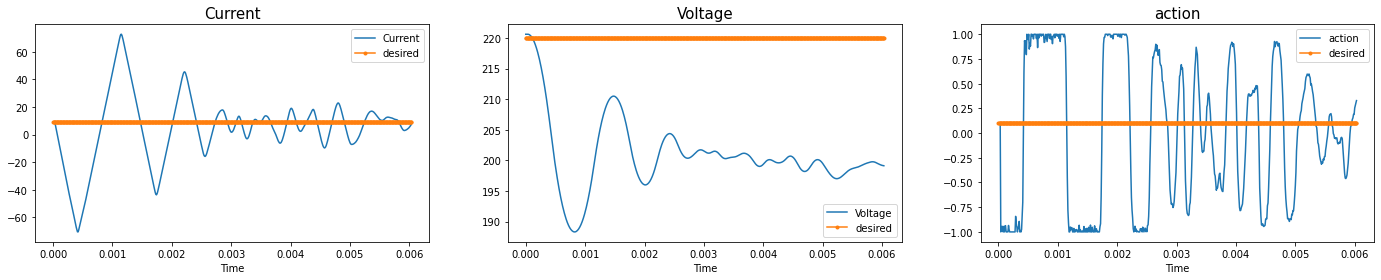

| Reward: -3025.0093 | Episode: 16 | Qmax: 10.5779


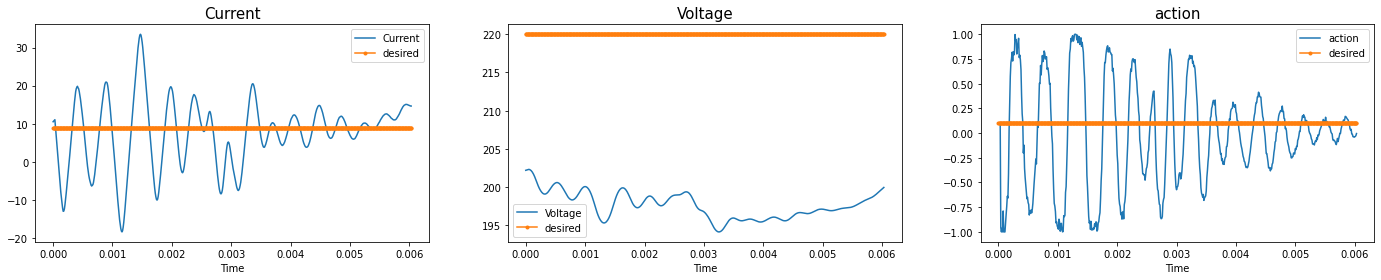

| Reward: -3872.2080 | Episode: 17 | Qmax: 10.1913


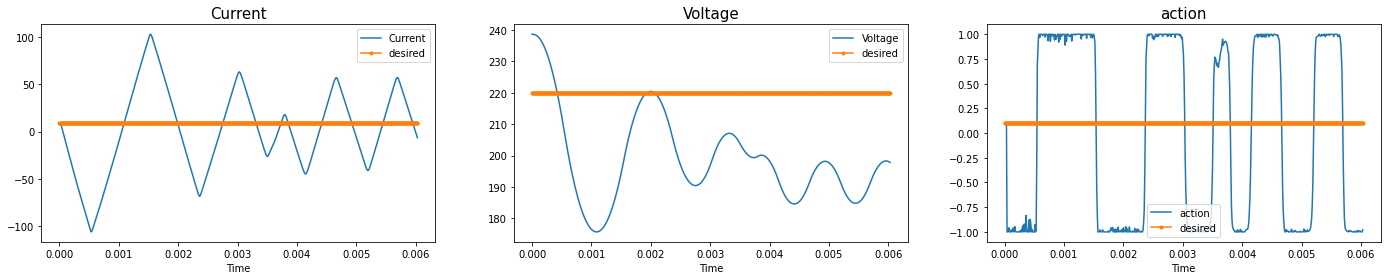

| Reward: -4229.7080 | Episode: 18 | Qmax: 10.4517


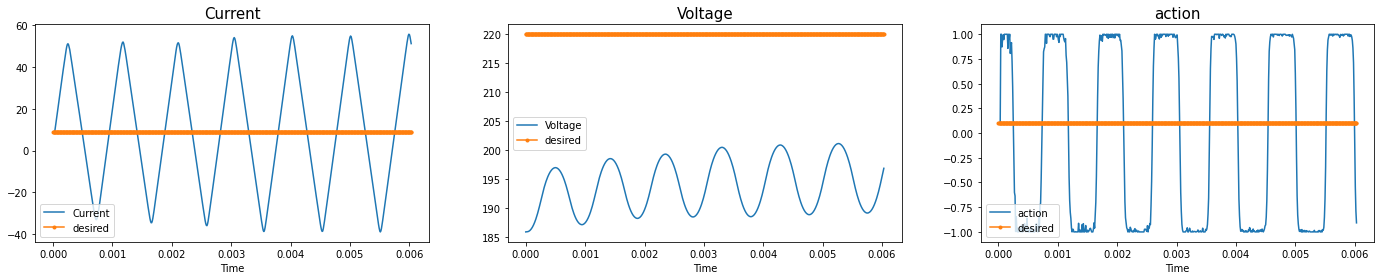

| Reward: -6926.9719 | Episode: 19 | Qmax: 8.4047


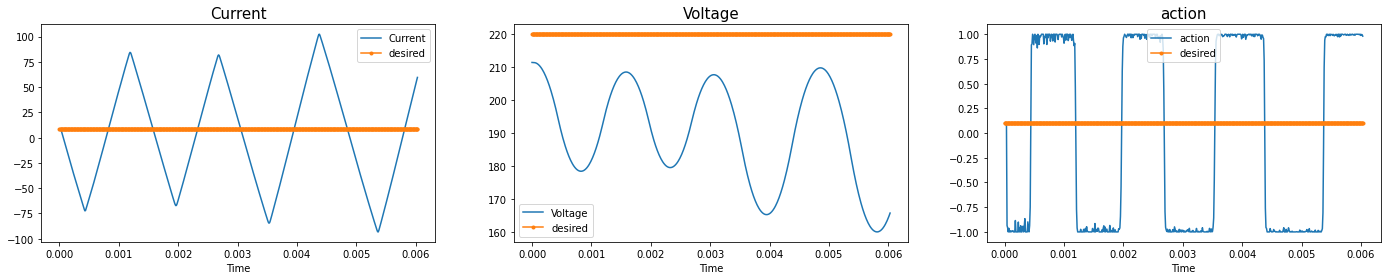

| Reward: -6761.1638 | Episode: 20 | Qmax: 8.9143


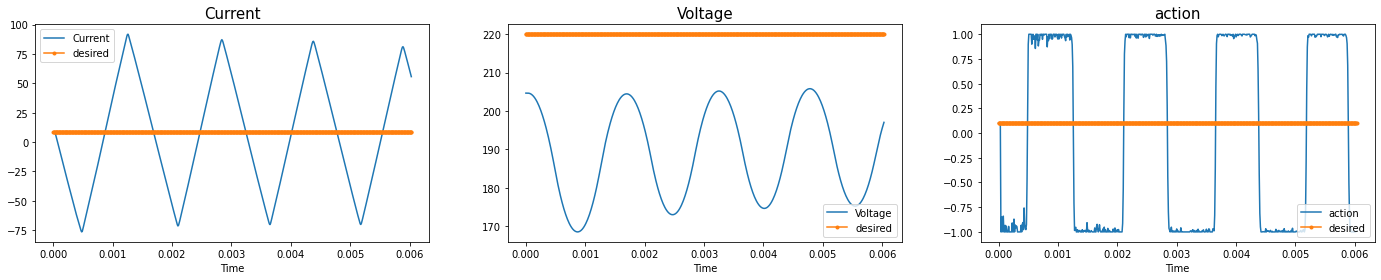

| Reward: -10773.3958 | Episode: 21 | Qmax: 7.8411


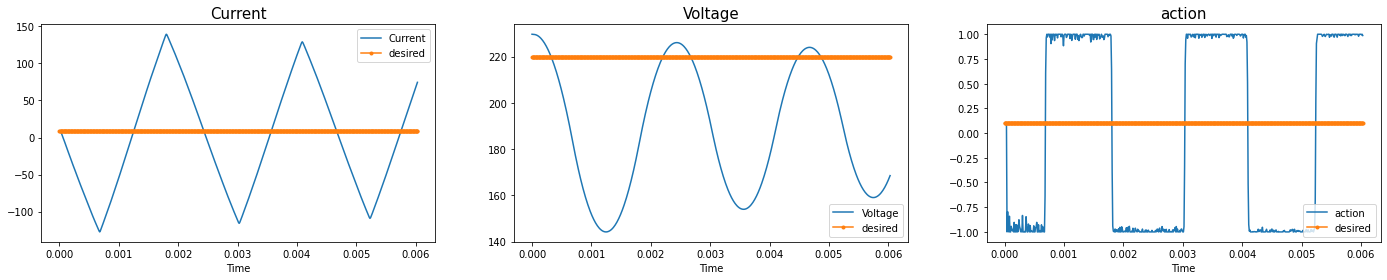

| Reward: -8675.3711 | Episode: 22 | Qmax: 7.3883


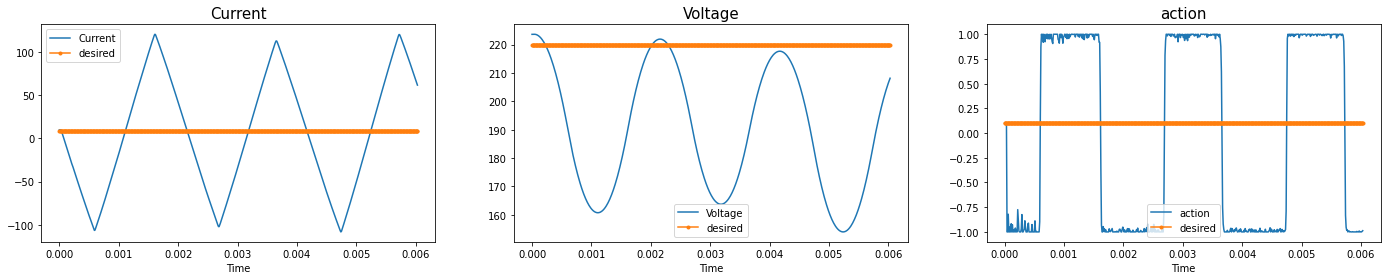

| Reward: -11382.5625 | Episode: 23 | Qmax: 7.5905


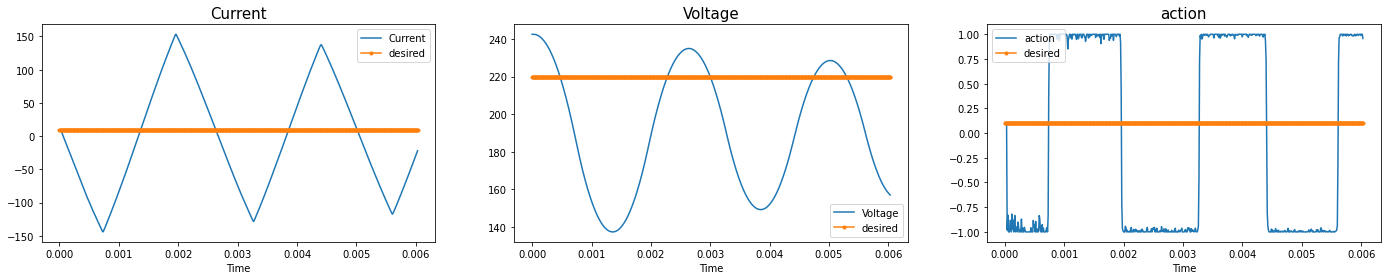

| Reward: -9160.6739 | Episode: 24 | Qmax: 7.5552


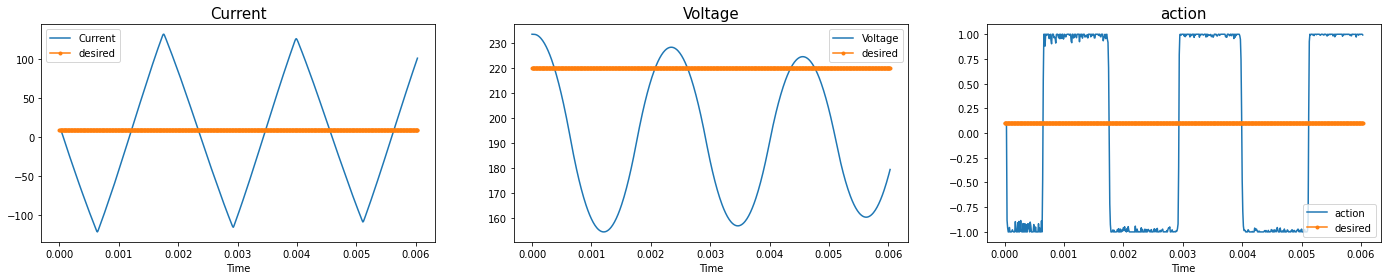

| Reward: -8196.6004 | Episode: 25 | Qmax: 6.4259


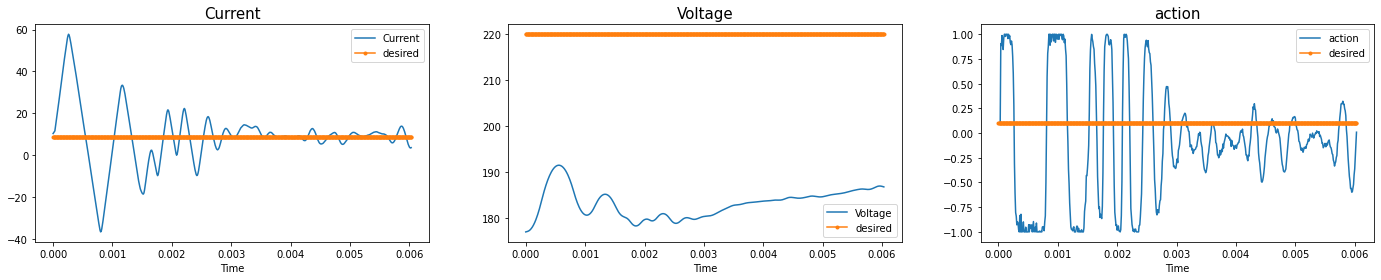

| Reward: -8809.0060 | Episode: 26 | Qmax: 3.6311


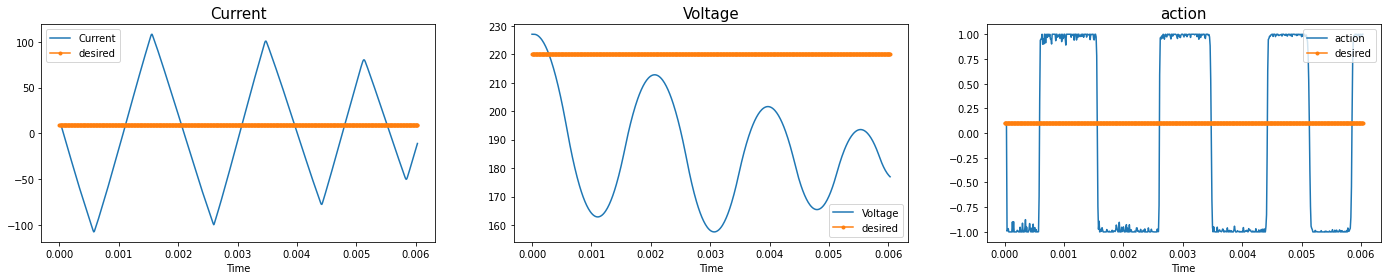

| Reward: -6888.8460 | Episode: 27 | Qmax: 5.2503


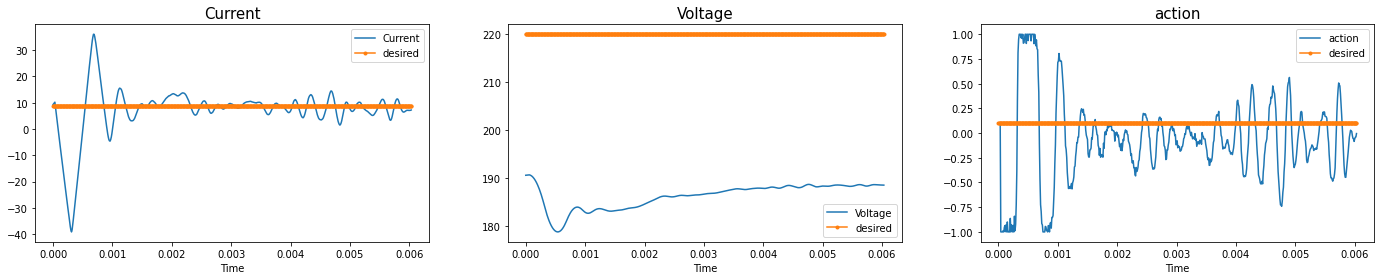

| Reward: -7033.7843 | Episode: 28 | Qmax: 3.8471


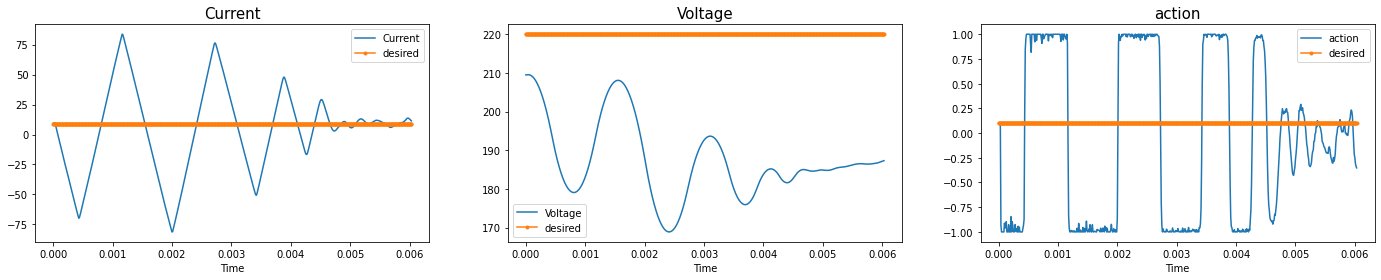

| Reward: -6806.7456 | Episode: 29 | Qmax: 3.2700


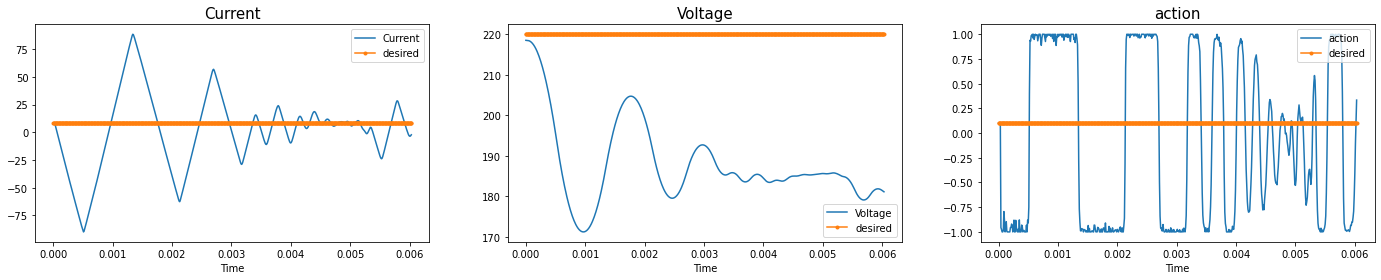

| Reward: -9126.9582 | Episode: 30 | Qmax: 1.4291


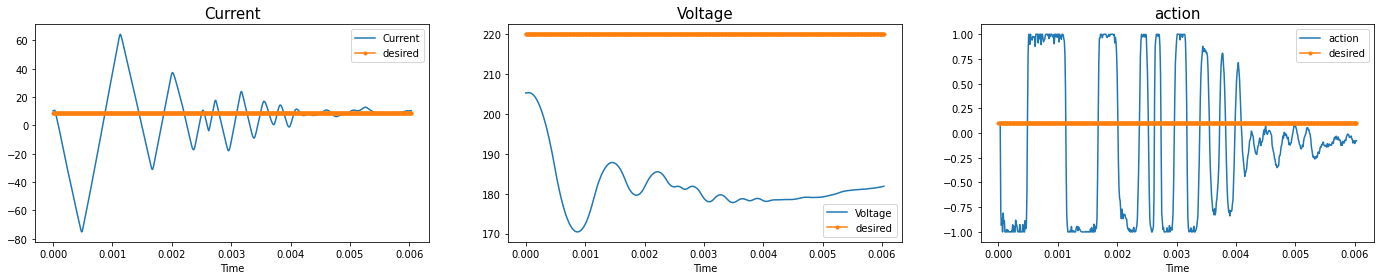

| Reward: -4725.6933 | Episode: 31 | Qmax: 2.1099


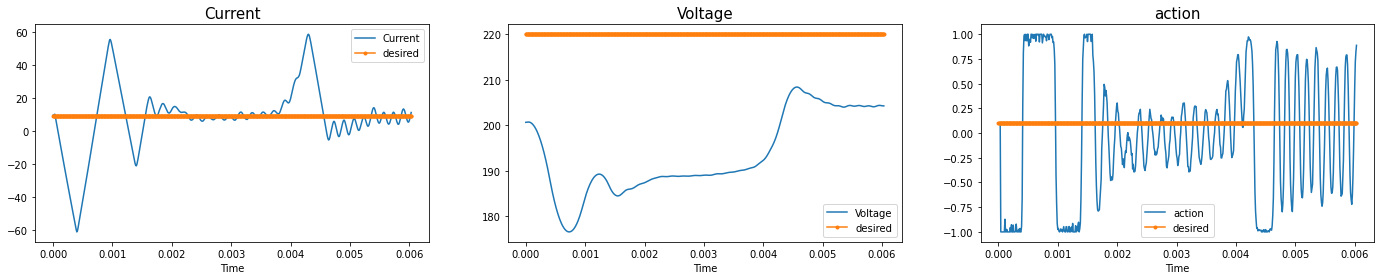

| Reward: -10621.3666 | Episode: 32 | Qmax: -1.8716


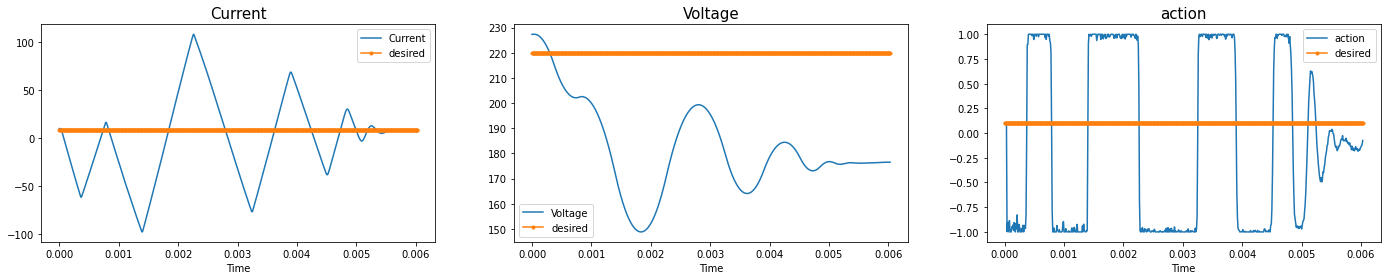

| Reward: -6466.8456 | Episode: 33 | Qmax: 0.1795


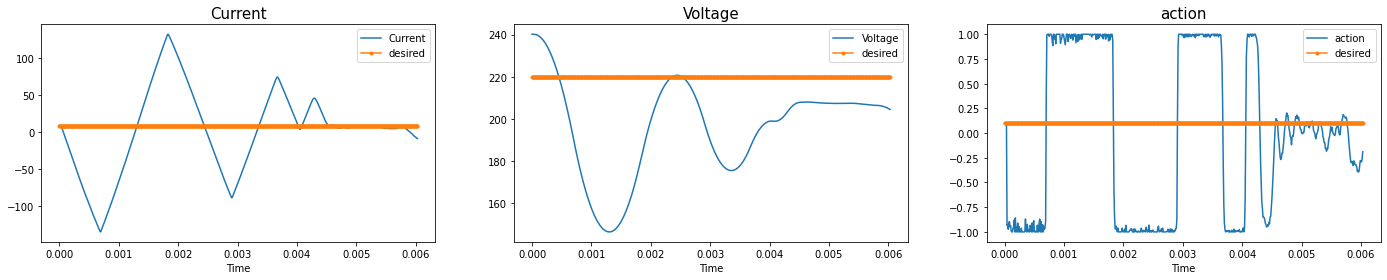

| Reward: -2220.8635 | Episode: 34 | Qmax: -1.3475


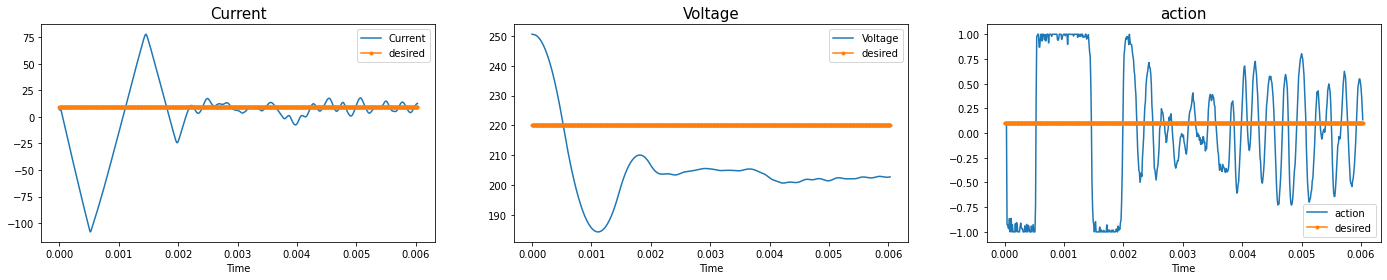

| Reward: -1510.8874 | Episode: 35 | Qmax: -0.7779


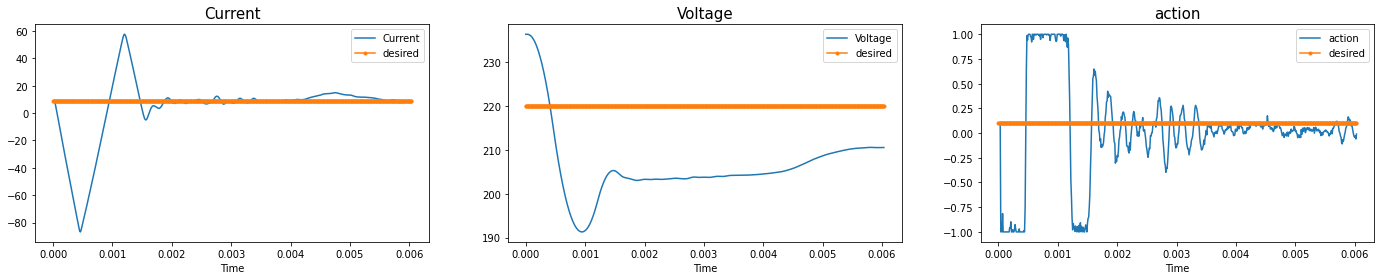

| Reward: -6072.6911 | Episode: 36 | Qmax: -2.9887


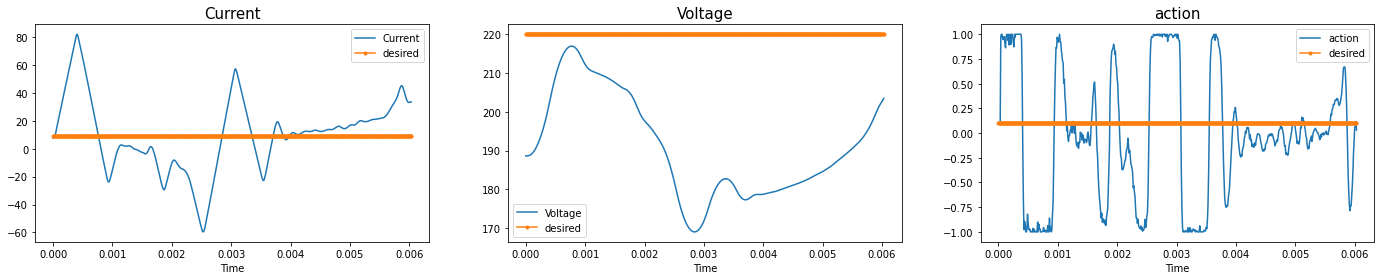

| Reward: -3248.1824 | Episode: 37 | Qmax: -4.3723


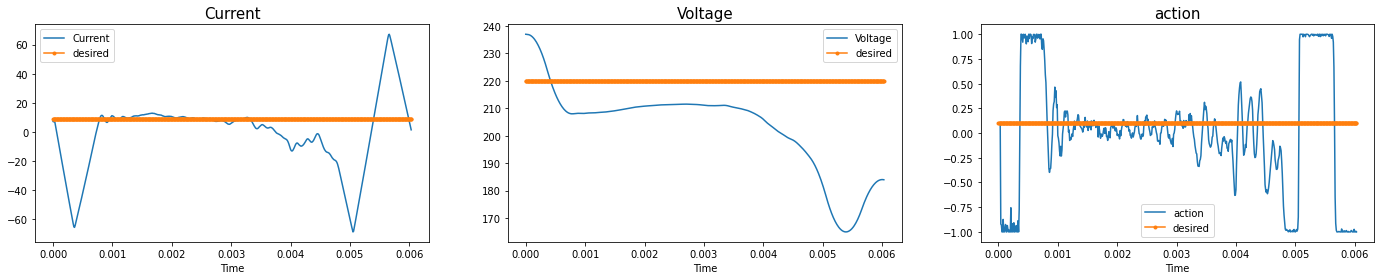

| Reward: -5123.3300 | Episode: 38 | Qmax: -4.1463


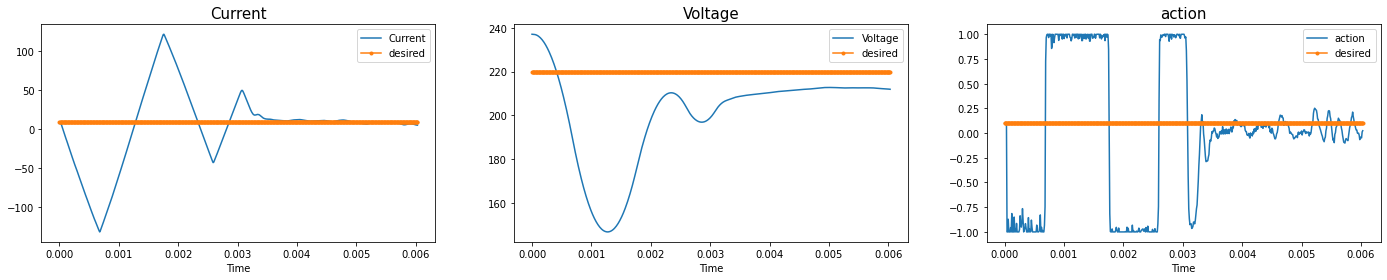

| Reward: -609.8625 | Episode: 39 | Qmax: -4.8054


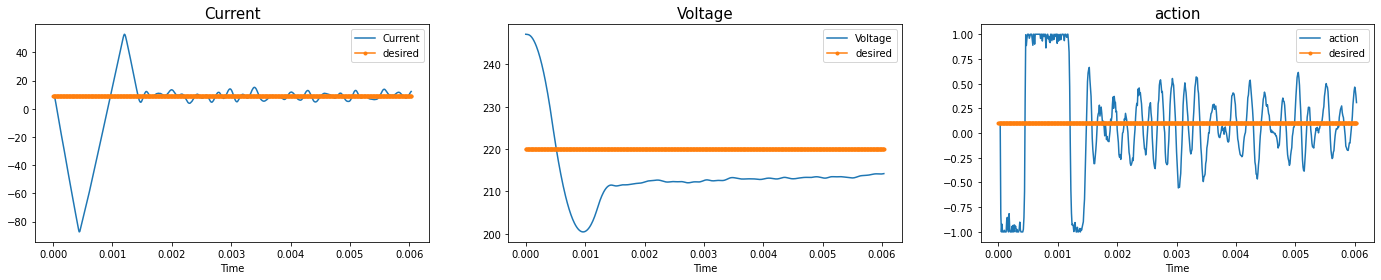

| Reward: -5175.5813 | Episode: 40 | Qmax: -7.8774


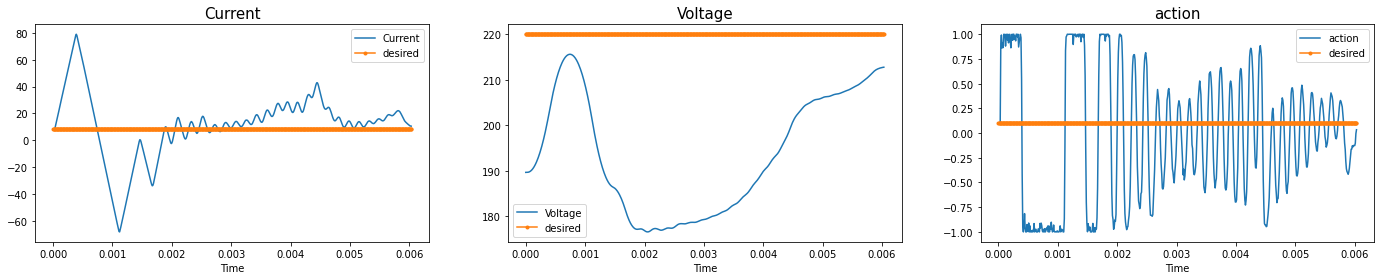

| Reward: -1080.3776 | Episode: 41 | Qmax: -6.0028


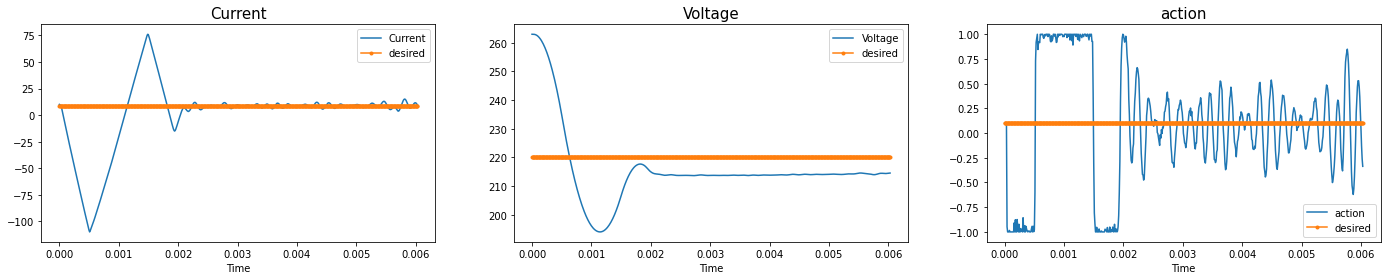

| Reward: -684.8586 | Episode: 42 | Qmax: -8.8035


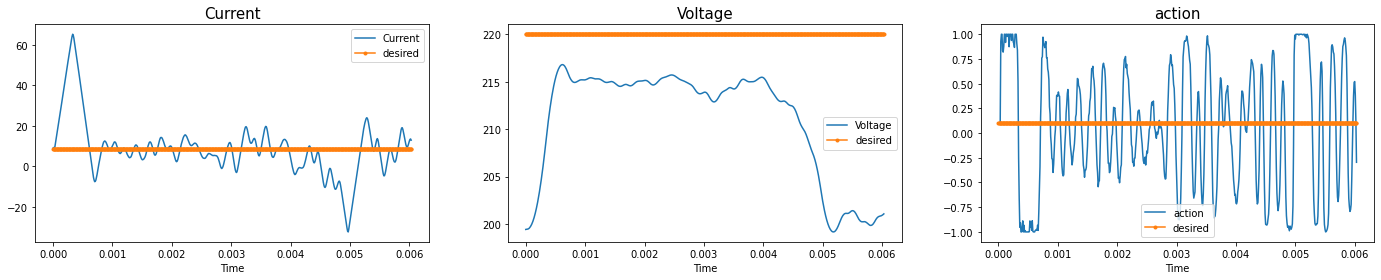

| Reward: -896.9312 | Episode: 43 | Qmax: -8.8787


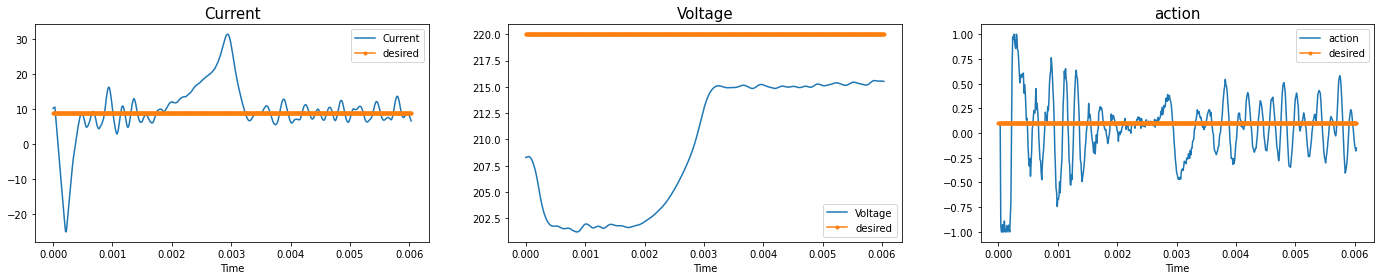

| Reward: -5703.6113 | Episode: 44 | Qmax: -12.1016


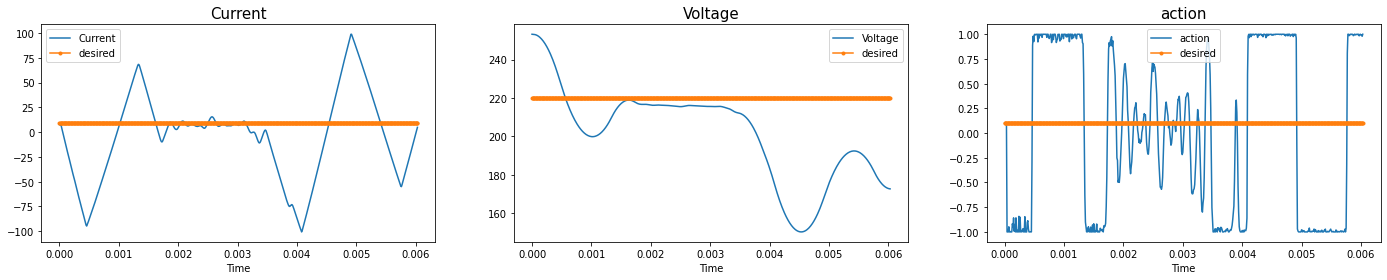

| Reward: -4916.3557 | Episode: 45 | Qmax: -10.3748


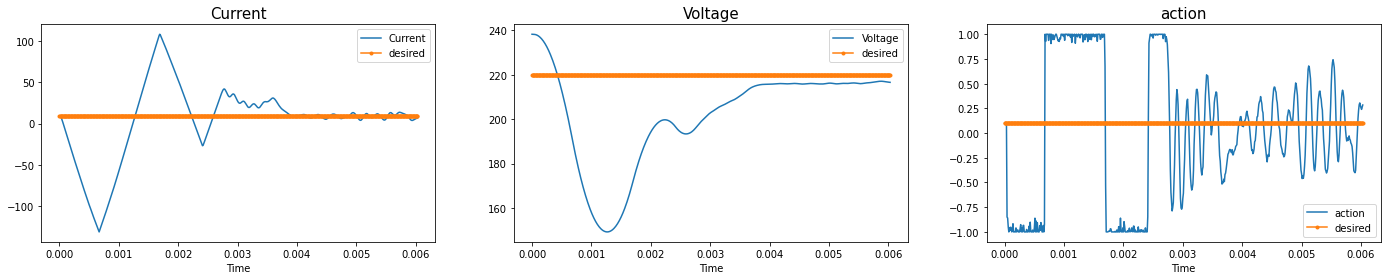

| Reward: -87.2975 | Episode: 46 | Qmax: -12.1646


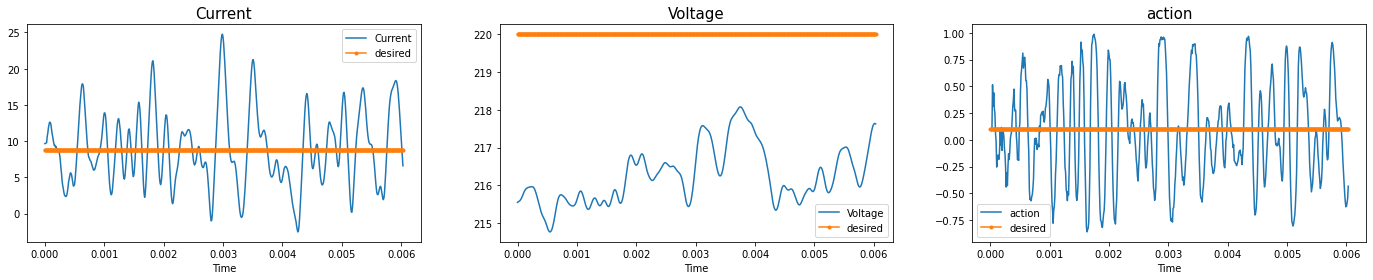

| Reward: -92.6641 | Episode: 47 | Qmax: -12.9877


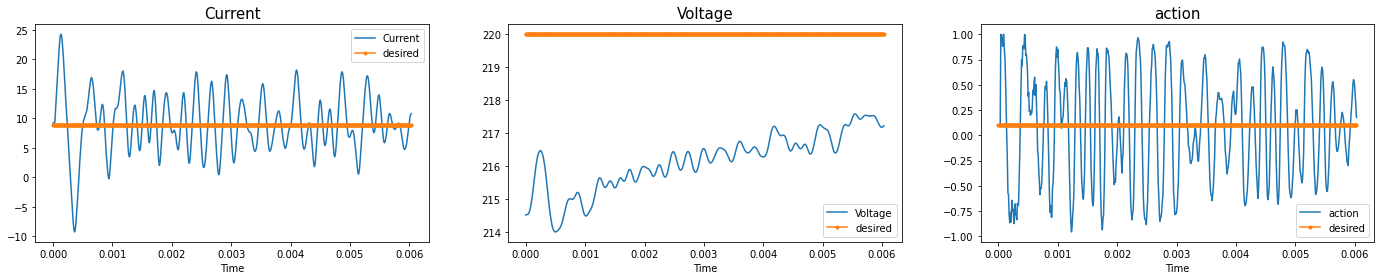

| Reward: -5447.0491 | Episode: 48 | Qmax: -15.8837


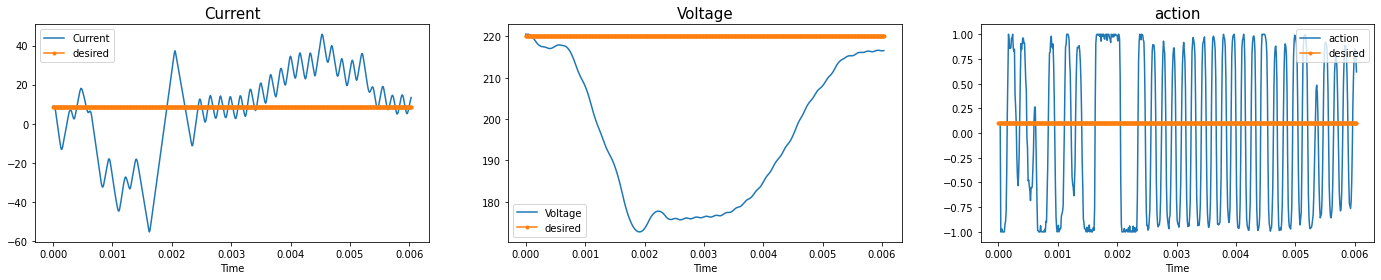

| Reward: -394.3744 | Episode: 49 | Qmax: -15.5363


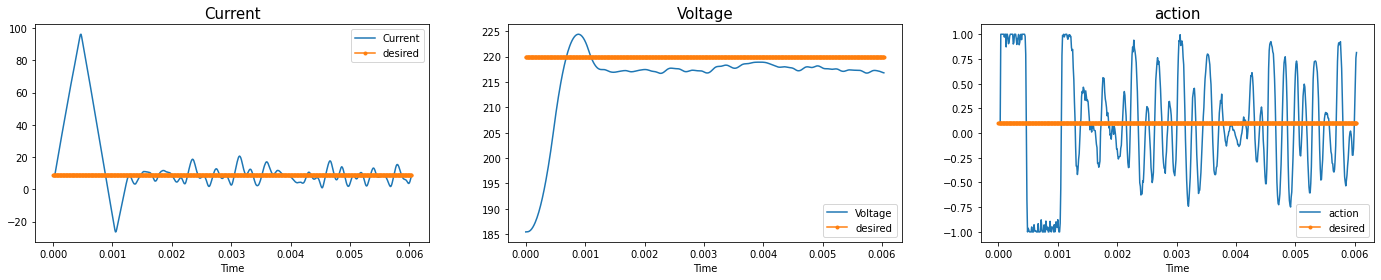

| Reward: -2801.4995 | Episode: 50 | Qmax: -17.9351


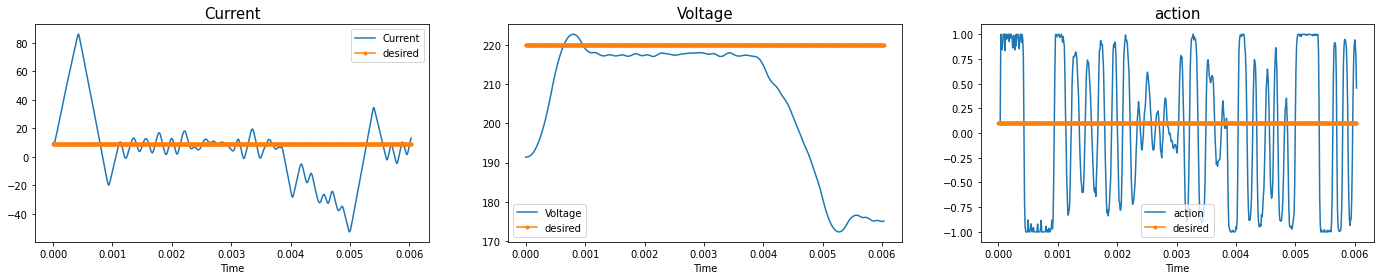

| Reward: -3127.5684 | Episode: 51 | Qmax: -18.4163


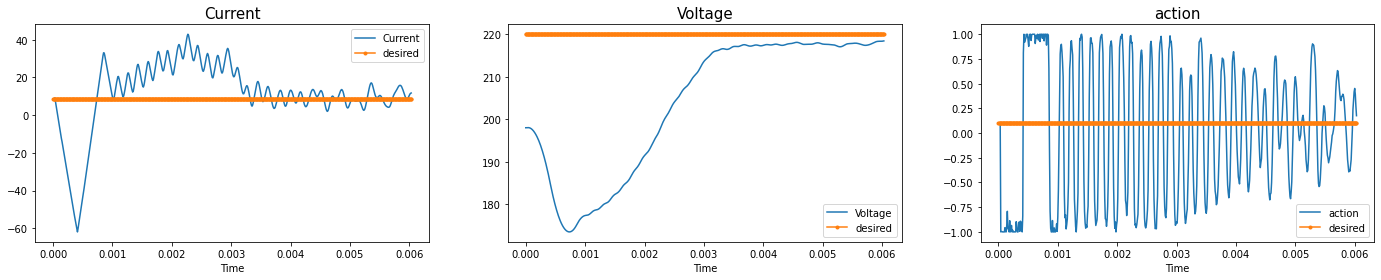

| Reward: -610.4298 | Episode: 52 | Qmax: -19.9033


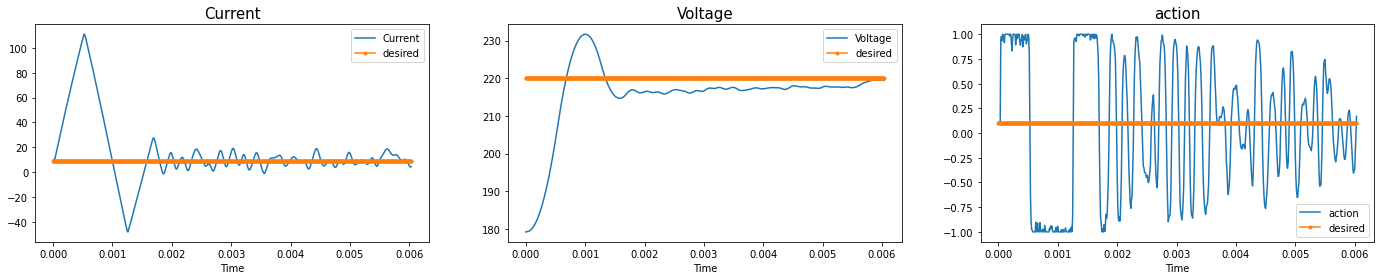

| Reward: -80.2982 | Episode: 53 | Qmax: -20.7776


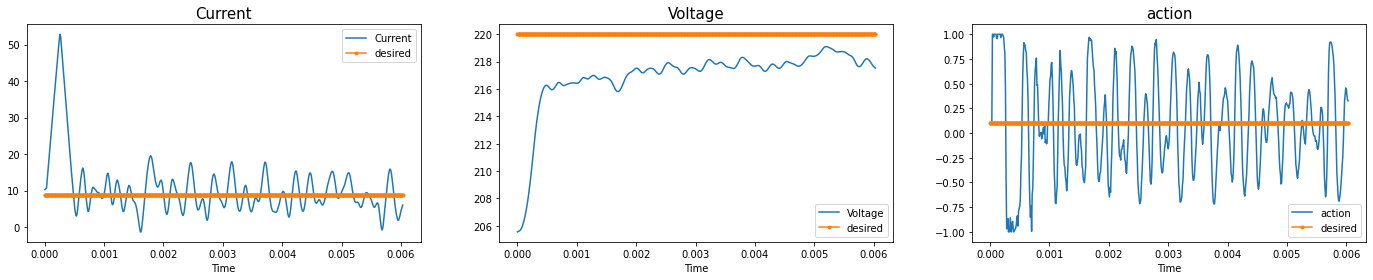

| Reward: -168.5279 | Episode: 54 | Qmax: -20.6893


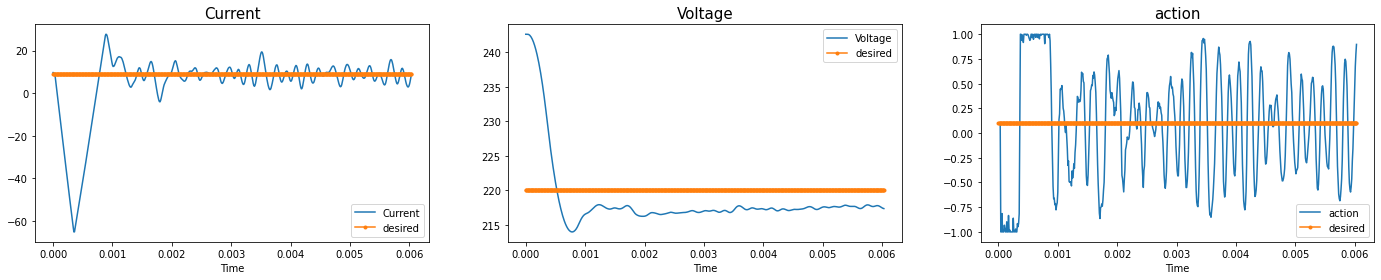

| Reward: -607.1032 | Episode: 55 | Qmax: -21.7129


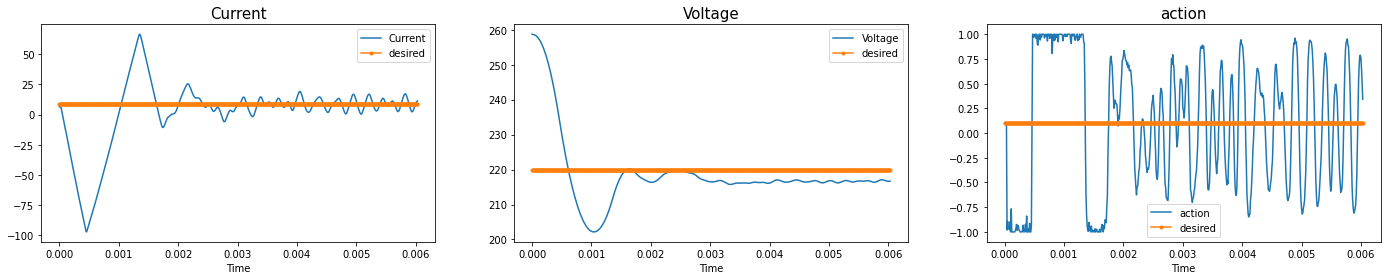

| Reward: -434.5196 | Episode: 56 | Qmax: -22.1768


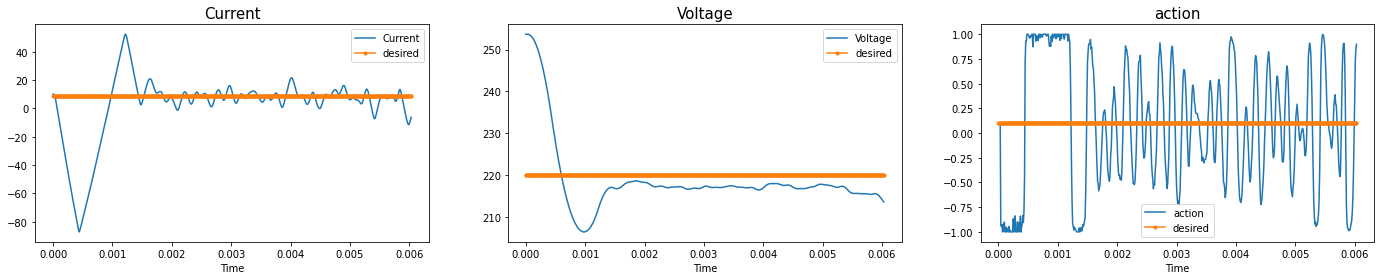

| Reward: -1632.8772 | Episode: 57 | Qmax: -24.6262


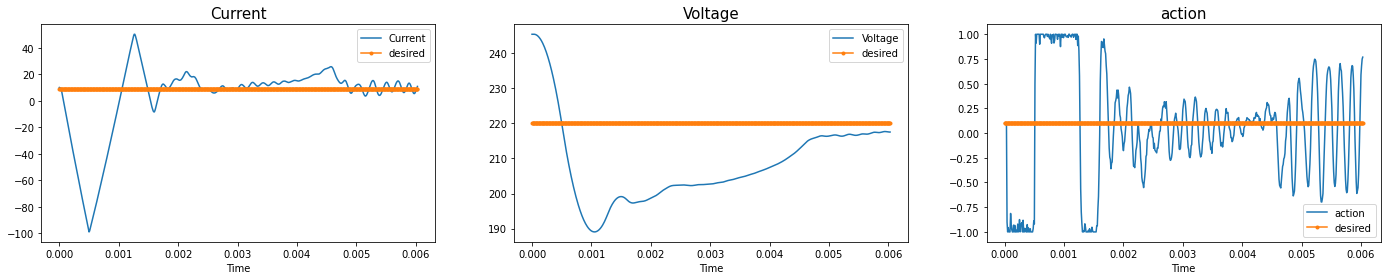

| Reward: -366.7261 | Episode: 58 | Qmax: -24.3483


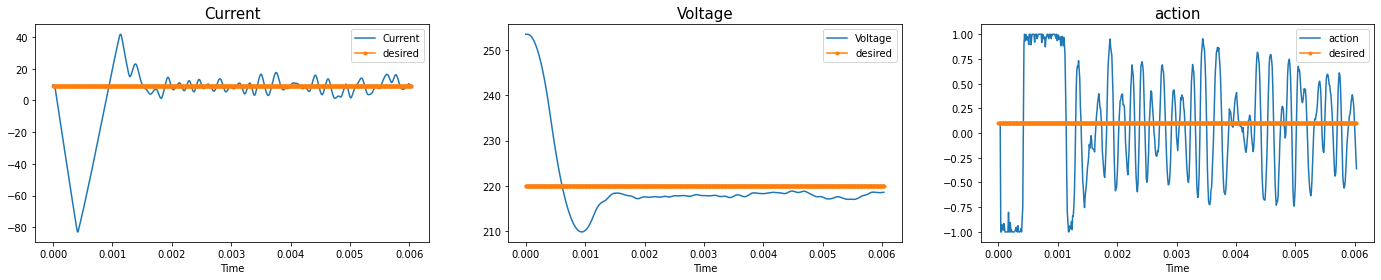

| Reward: -69.2801 | Episode: 59 | Qmax: -24.8120


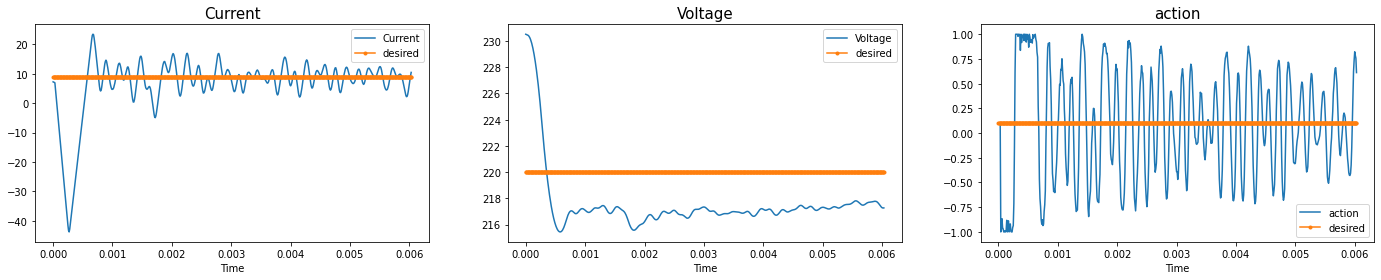

| Reward: -593.3671 | Episode: 60 | Qmax: -25.7868


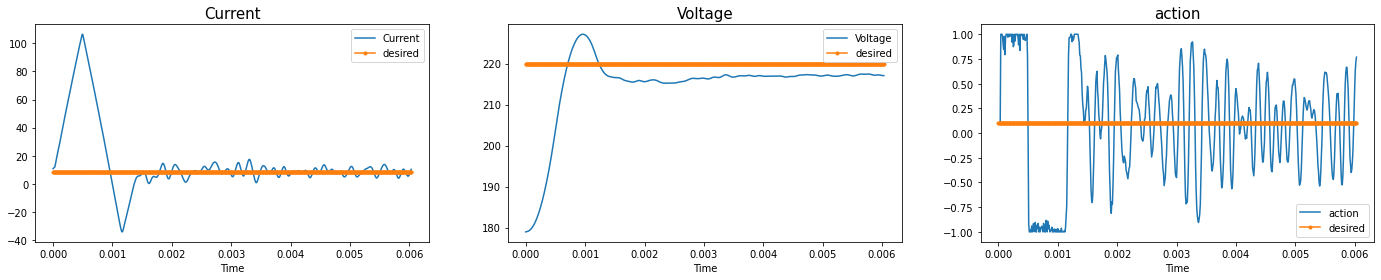

| Reward: -338.8571 | Episode: 61 | Qmax: -25.8152


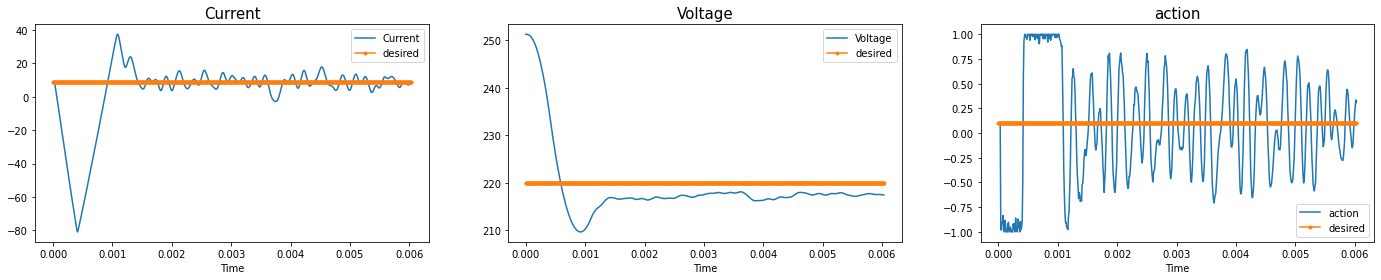

| Reward: -295.9929 | Episode: 62 | Qmax: -27.4349


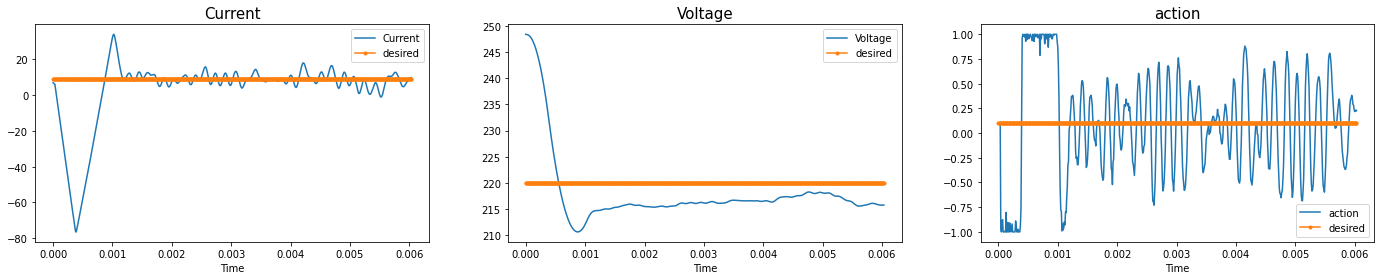

| Reward: -85.7066 | Episode: 63 | Qmax: -27.6696


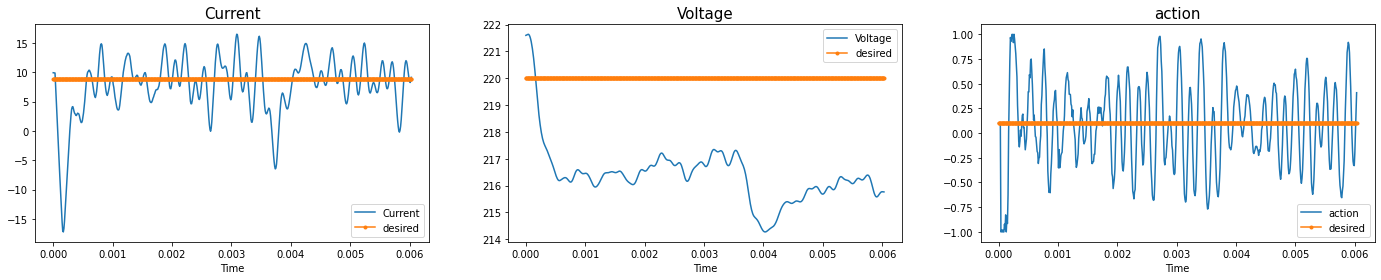

| Reward: -666.3169 | Episode: 64 | Qmax: -28.1611


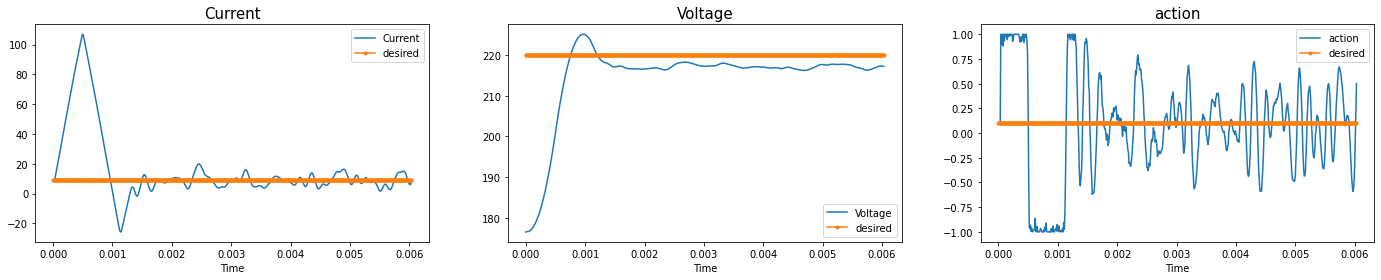

| Reward: -122.7422 | Episode: 65 | Qmax: -29.5332


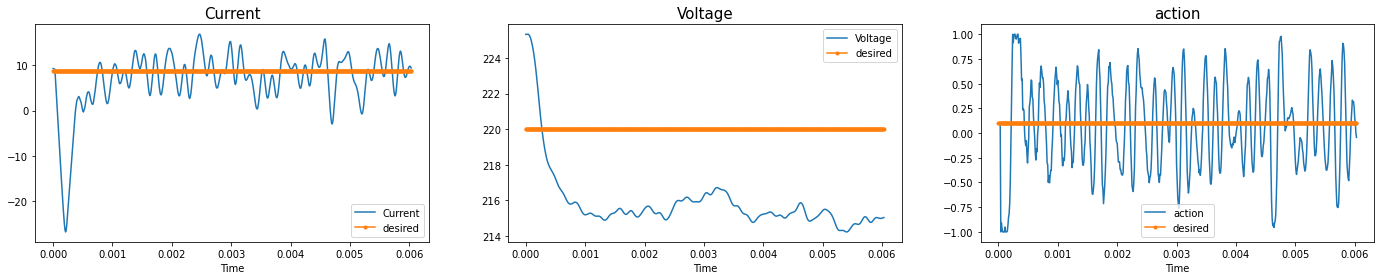

| Reward: -144.6319 | Episode: 66 | Qmax: -29.4599


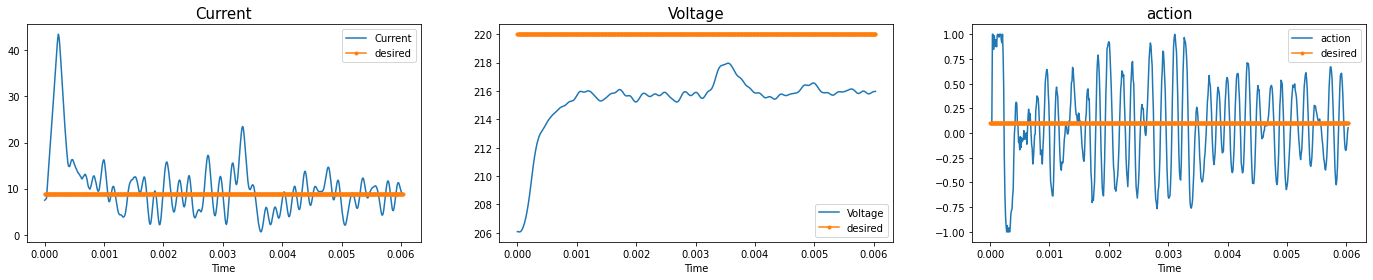

| Reward: -276.1490 | Episode: 67 | Qmax: -30.4649


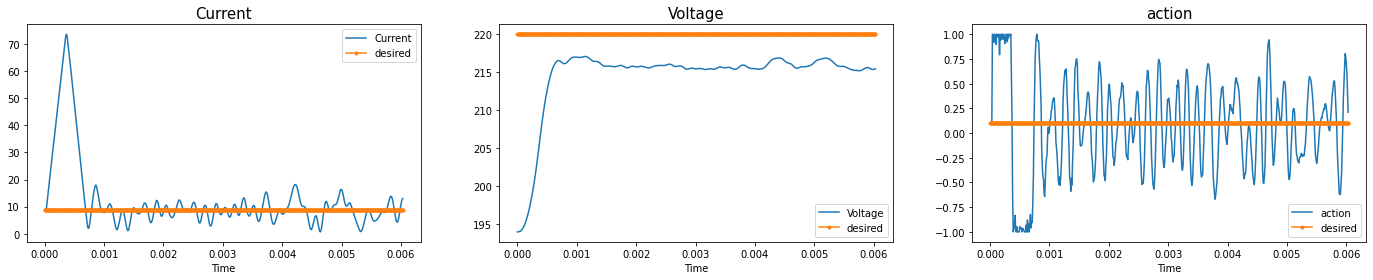

| Reward: -417.7700 | Episode: 68 | Qmax: -30.6748


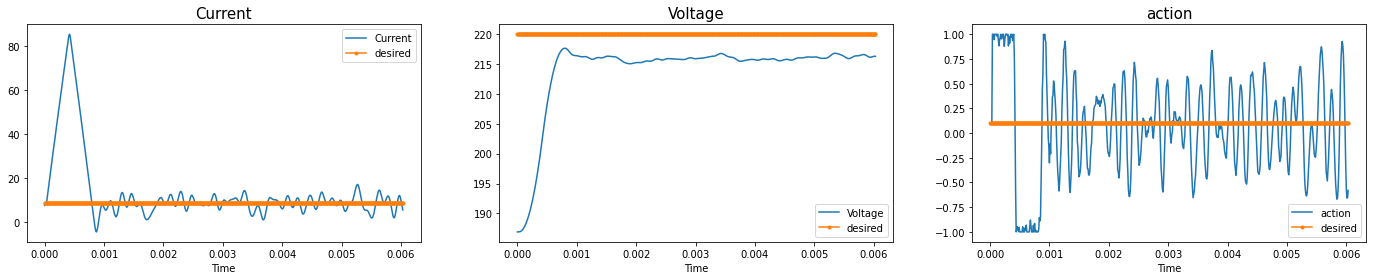

| Reward: -418.6269 | Episode: 69 | Qmax: -31.4604


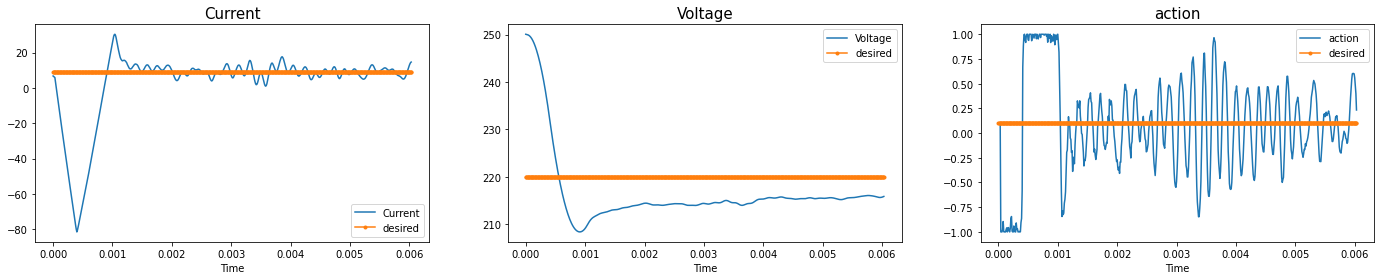

| Reward: -107.2931 | Episode: 70 | Qmax: -31.6851


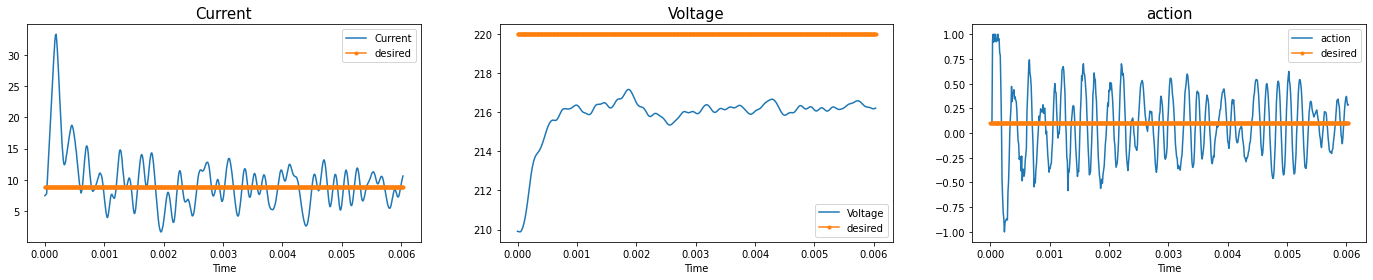

| Reward: -140.1142 | Episode: 71 | Qmax: -32.2805


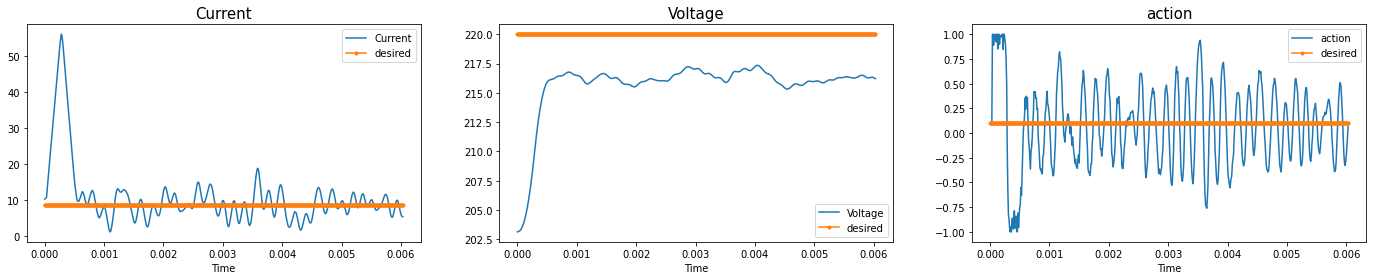

| Reward: -220.7198 | Episode: 72 | Qmax: -33.2618


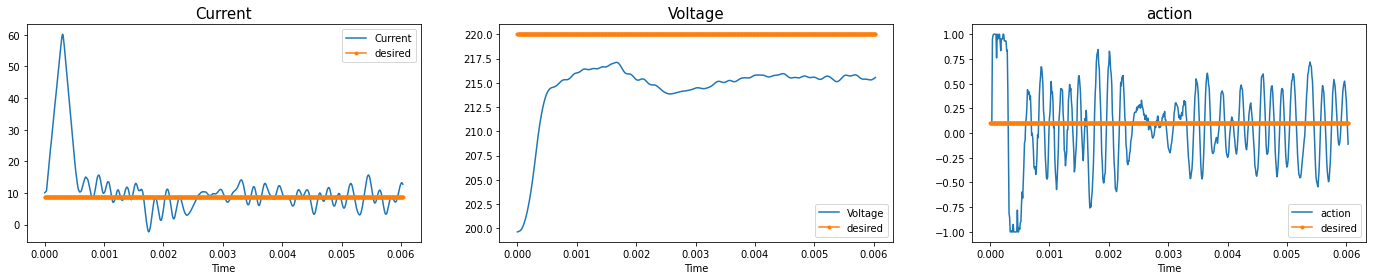

| Reward: -385.6774 | Episode: 73 | Qmax: -32.8808


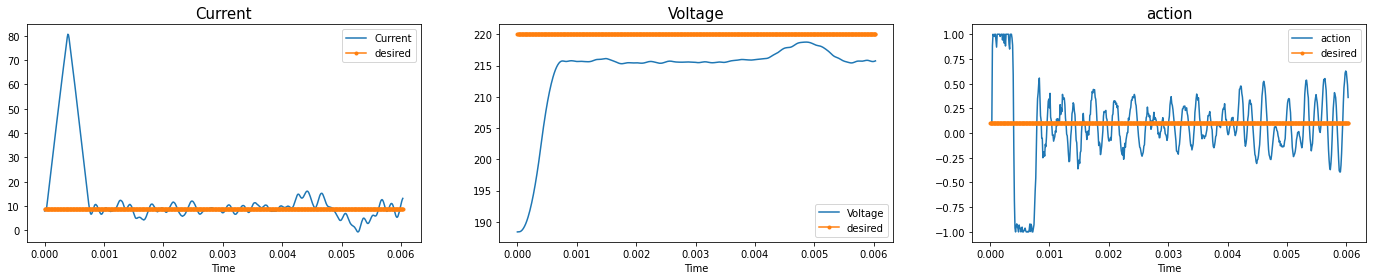

| Reward: -131.6825 | Episode: 74 | Qmax: -33.1080


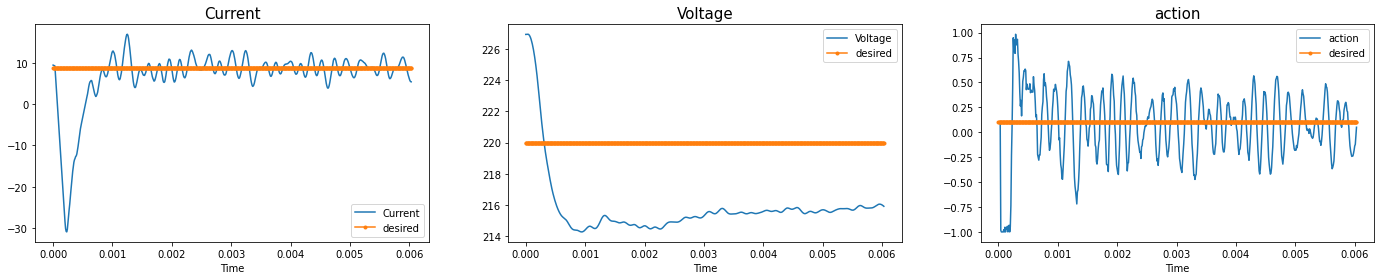

| Reward: -618.8351 | Episode: 75 | Qmax: -33.3060


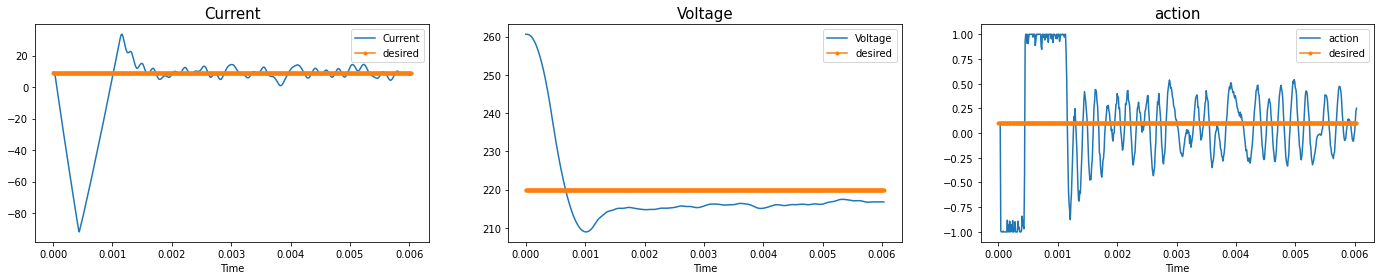

| Reward: -284.3579 | Episode: 76 | Qmax: -33.3885


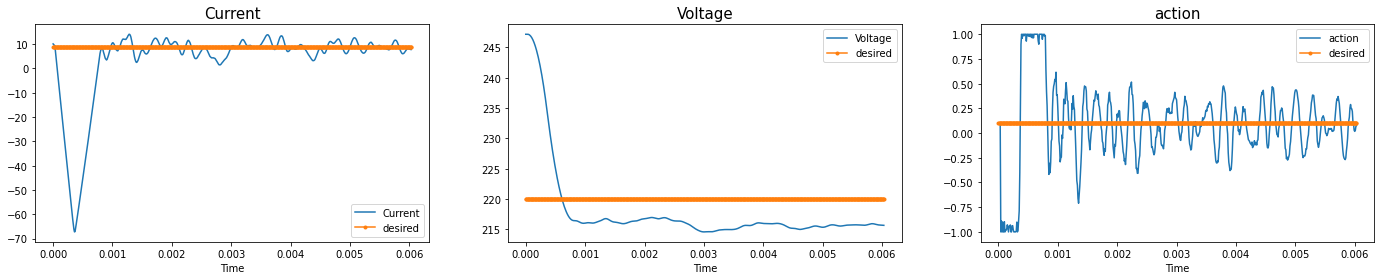

| Reward: -293.7634 | Episode: 77 | Qmax: -34.1237


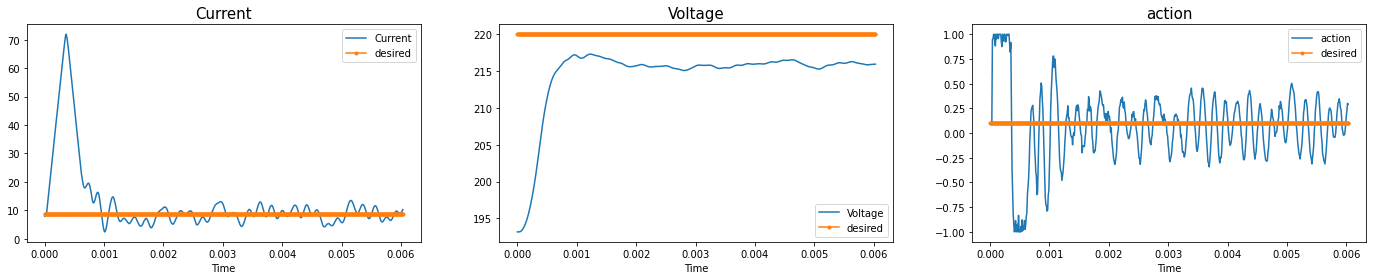

| Reward: -176.0035 | Episode: 78 | Qmax: -34.0204


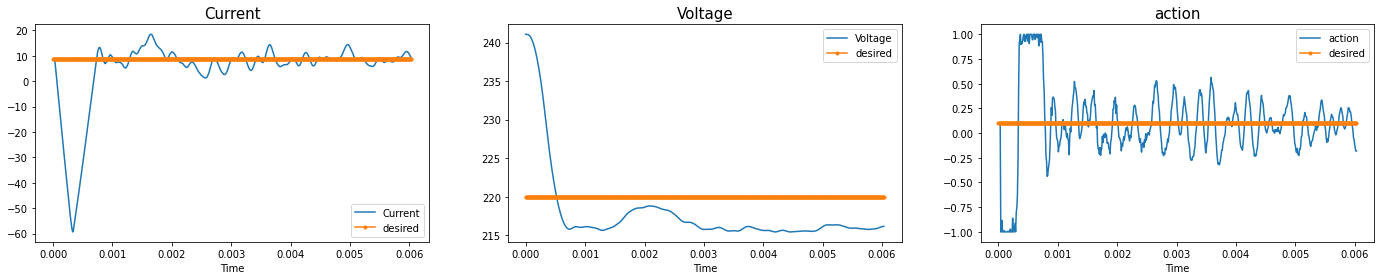

| Reward: -80.5677 | Episode: 79 | Qmax: -34.2946


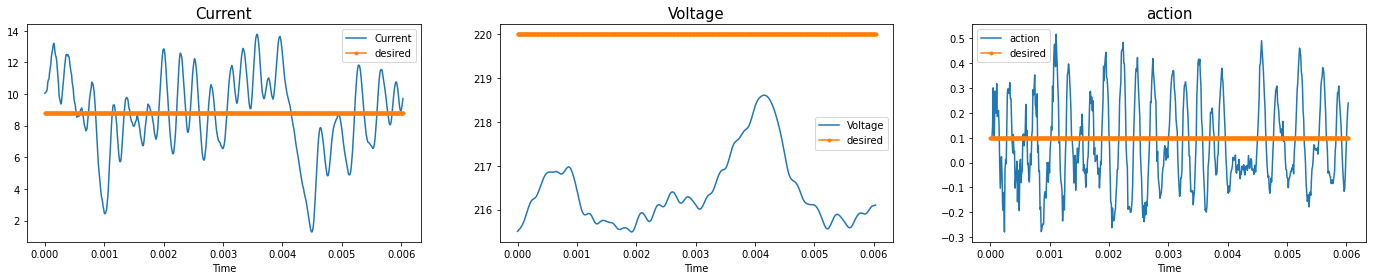

| Reward: -627.8258 | Episode: 80 | Qmax: -35.2358


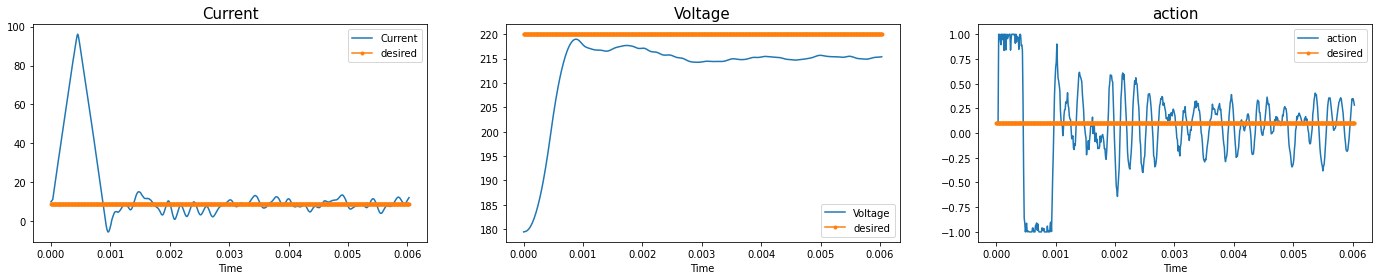

| Reward: -242.7694 | Episode: 81 | Qmax: -35.4646


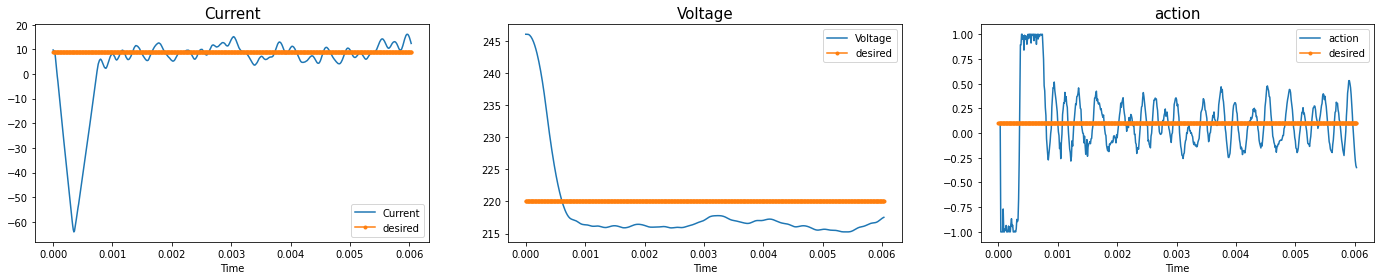

| Reward: -461.2240 | Episode: 82 | Qmax: -36.3264


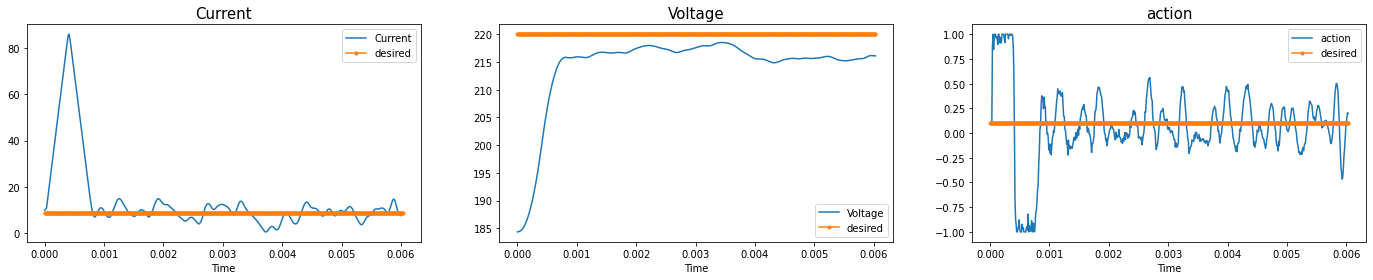

| Reward: -167.7574 | Episode: 83 | Qmax: -36.4994


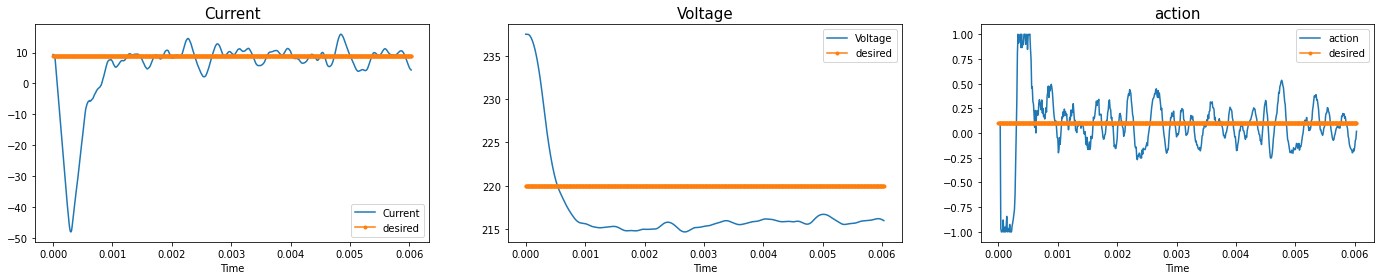

| Reward: -156.6266 | Episode: 84 | Qmax: -36.7093


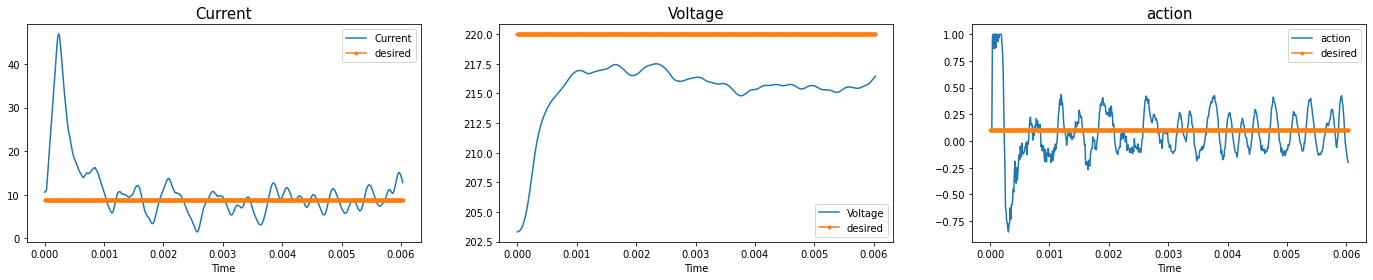

| Reward: -658.9355 | Episode: 85 | Qmax: -37.0074


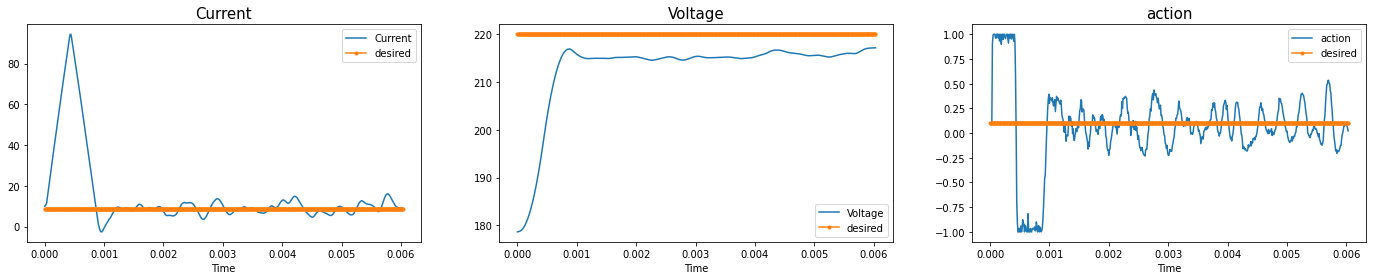

| Reward: -103.5563 | Episode: 86 | Qmax: -37.5469


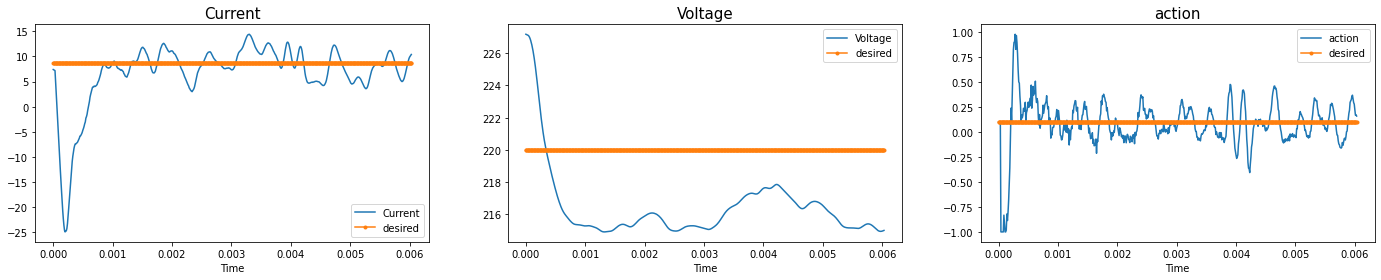

| Reward: -387.1278 | Episode: 87 | Qmax: -37.7469


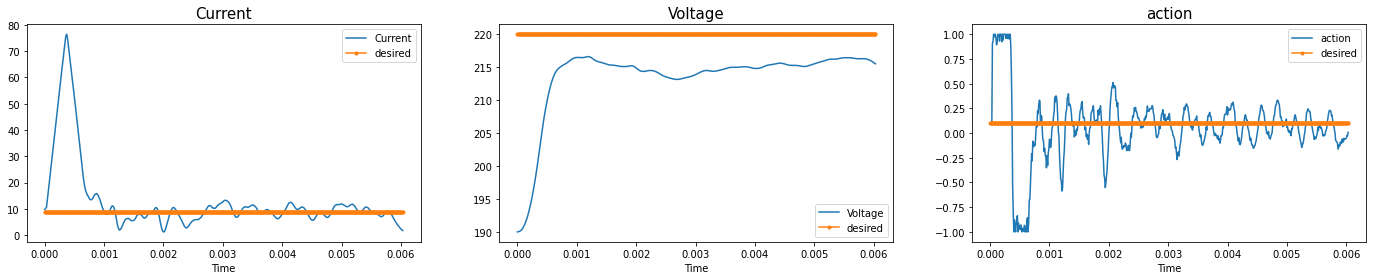

| Reward: -80.0584 | Episode: 88 | Qmax: -38.1665


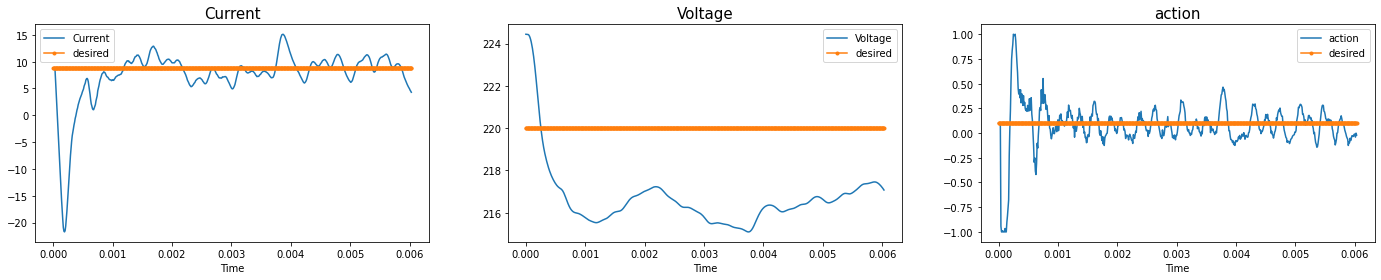

| Reward: -733.1991 | Episode: 89 | Qmax: -38.8823


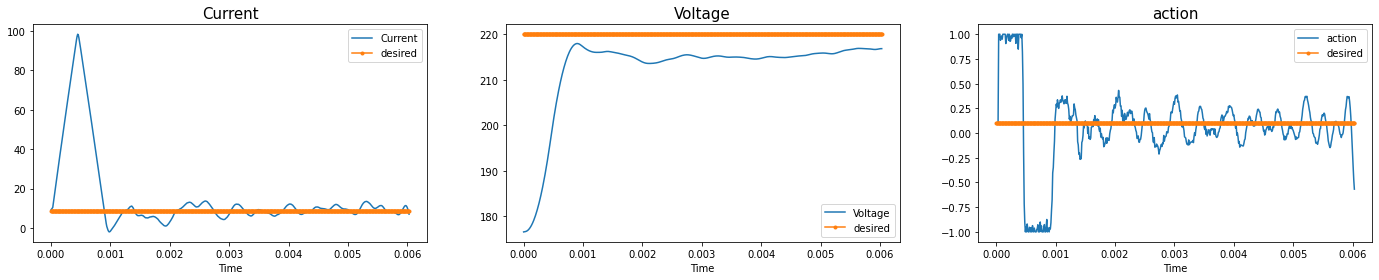

| Reward: -195.2726 | Episode: 90 | Qmax: -38.8509


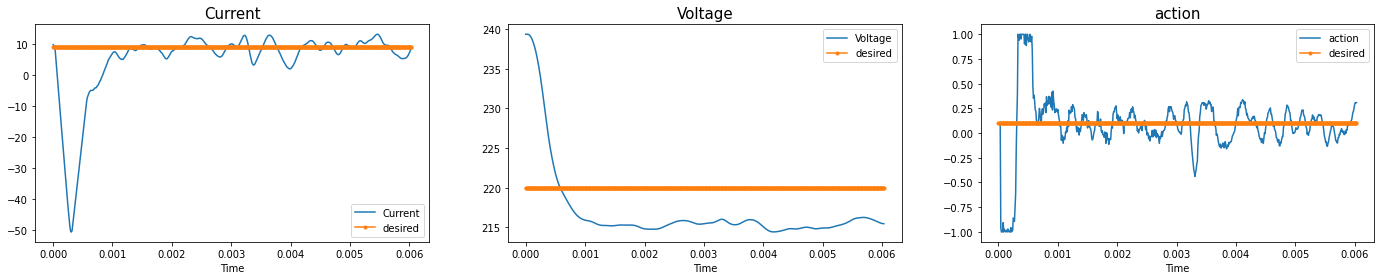

| Reward: -609.8737 | Episode: 91 | Qmax: -38.9169


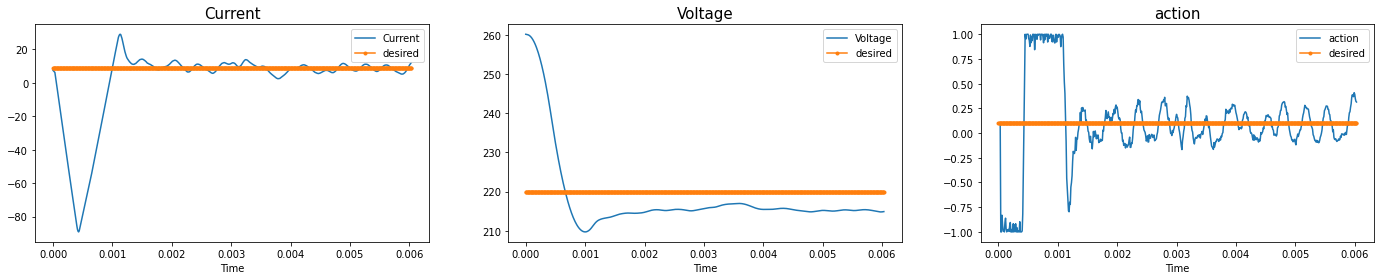

| Reward: -164.5897 | Episode: 92 | Qmax: -39.3644


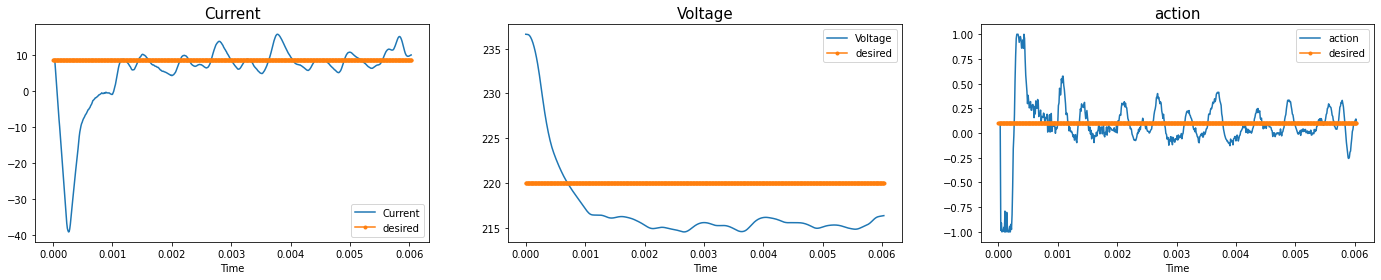

| Reward: -187.0467 | Episode: 93 | Qmax: -39.4857


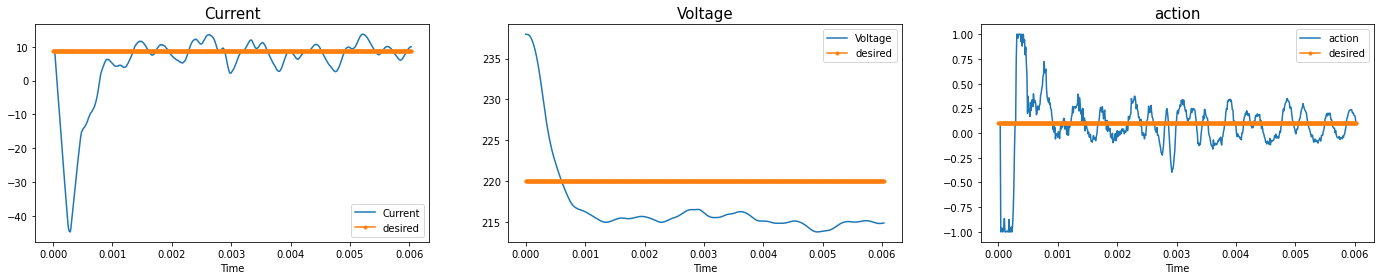

| Reward: -132.2629 | Episode: 94 | Qmax: -39.5995


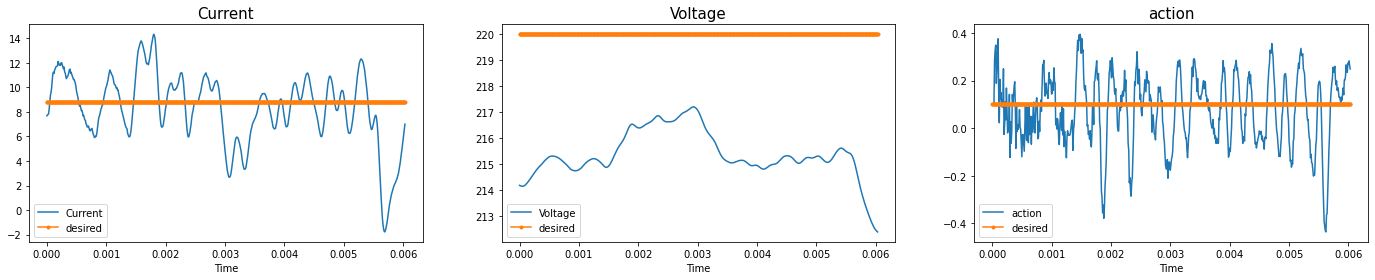

| Reward: -397.3855 | Episode: 95 | Qmax: -39.3884


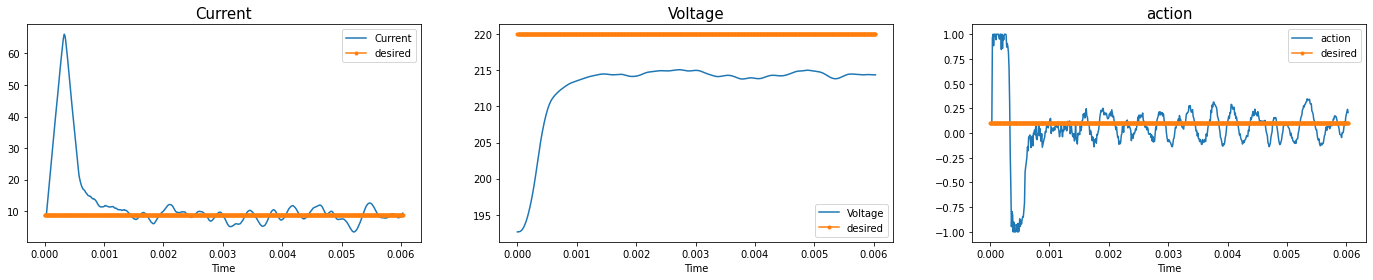

| Reward: -307.1208 | Episode: 96 | Qmax: -39.2117


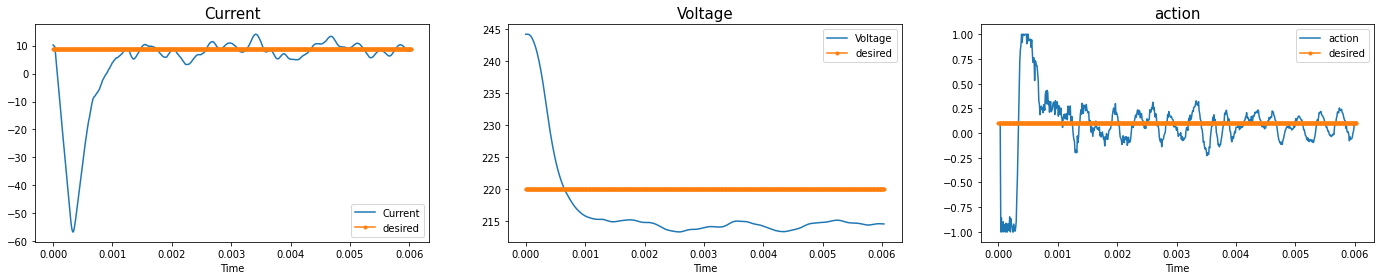

| Reward: -108.1802 | Episode: 97 | Qmax: -39.1993


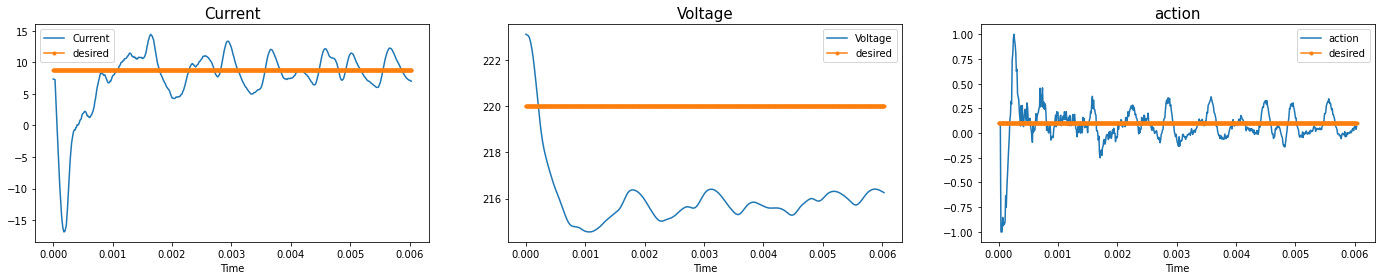

| Reward: -368.8633 | Episode: 98 | Qmax: -39.2419


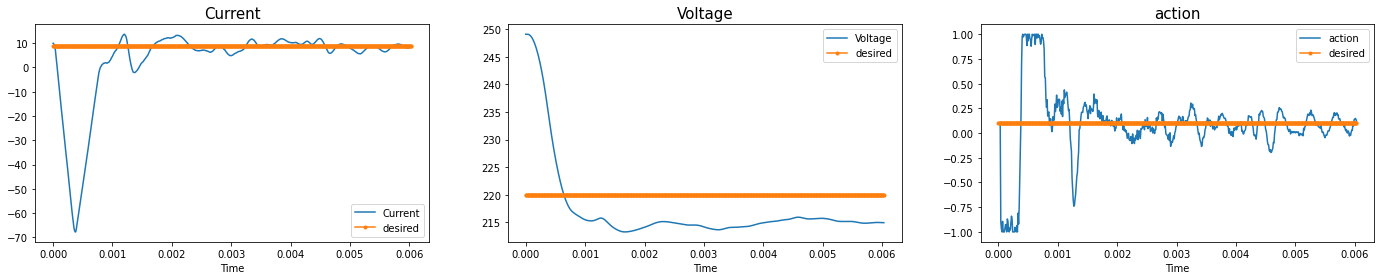

| Reward: -108.5966 | Episode: 99 | Qmax: -38.9805


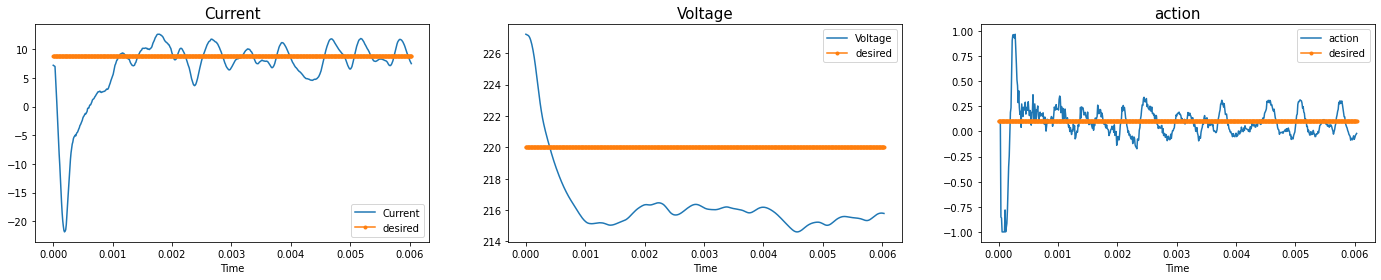

| Reward: -106.3299 | Episode: 100 | Qmax: -38.9256


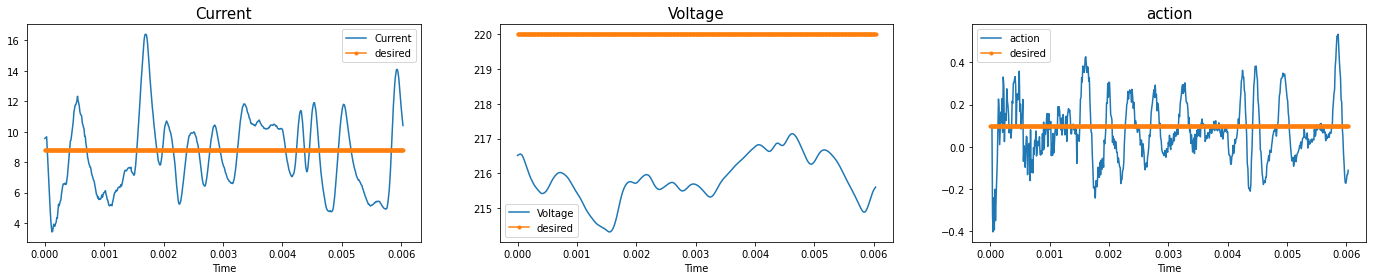

| Reward: -325.5179 | Episode: 101 | Qmax: -38.4536


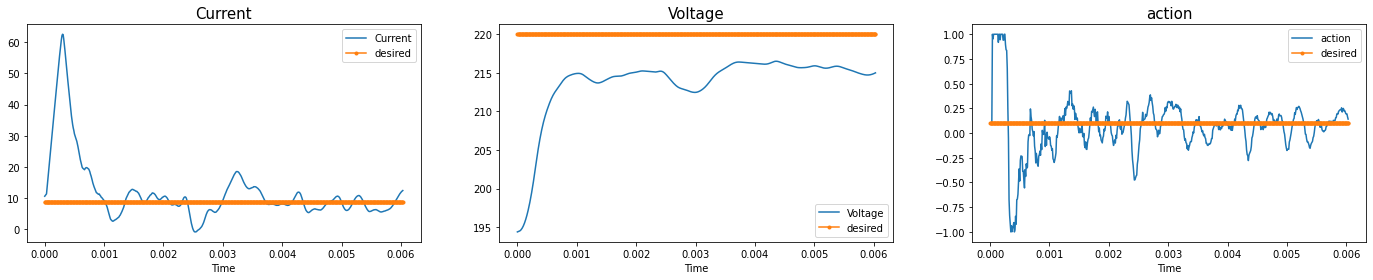

| Reward: -126.8595 | Episode: 102 | Qmax: -37.9224


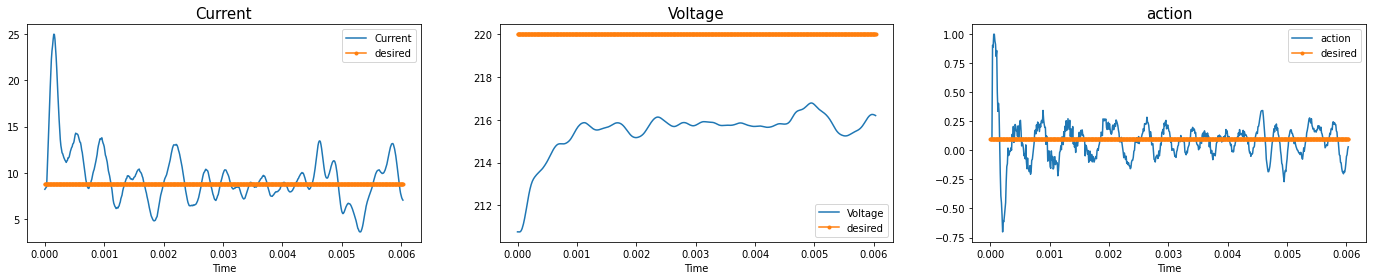

| Reward: -191.8203 | Episode: 103 | Qmax: -37.3319


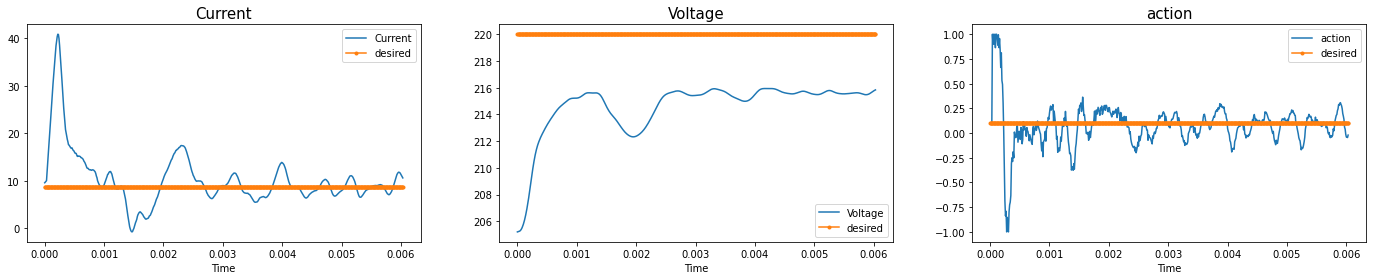

| Reward: -348.7902 | Episode: 104 | Qmax: -37.4353


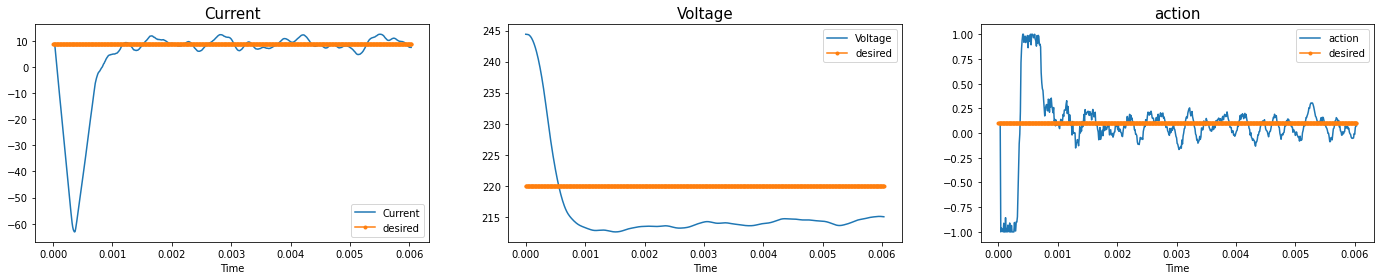

| Reward: -136.6020 | Episode: 105 | Qmax: -36.9105


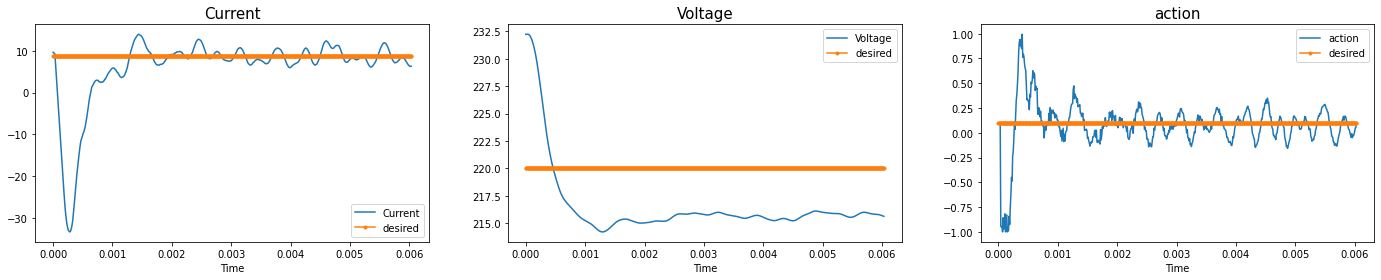

| Reward: -121.8614 | Episode: 106 | Qmax: -36.0761


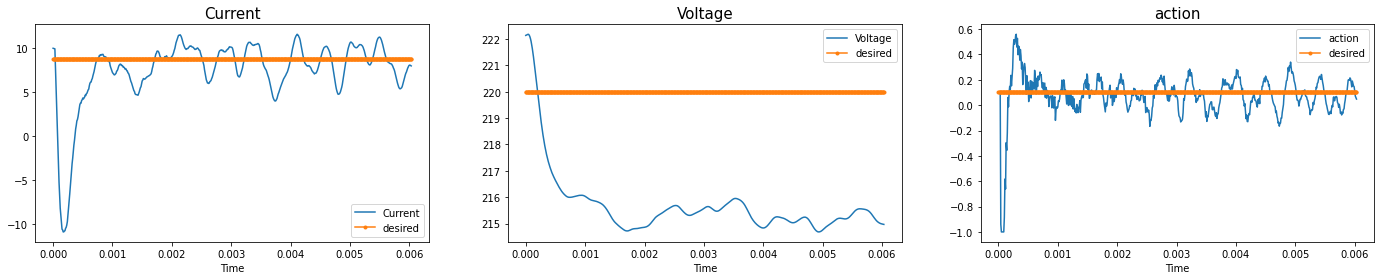

| Reward: -172.3361 | Episode: 107 | Qmax: -35.6579


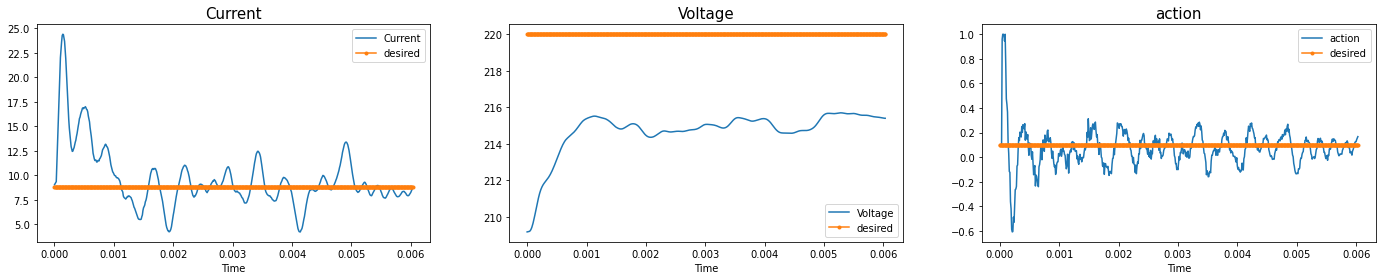

| Reward: -173.4571 | Episode: 108 | Qmax: -34.8844


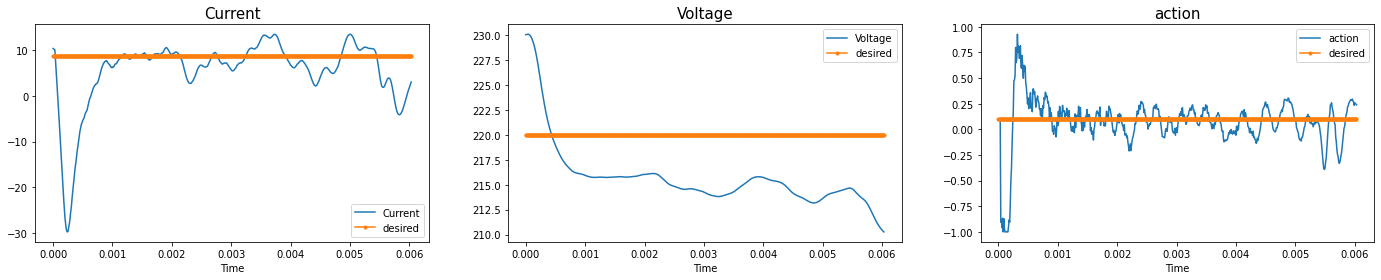

| Reward: -146.5788 | Episode: 109 | Qmax: -33.7240


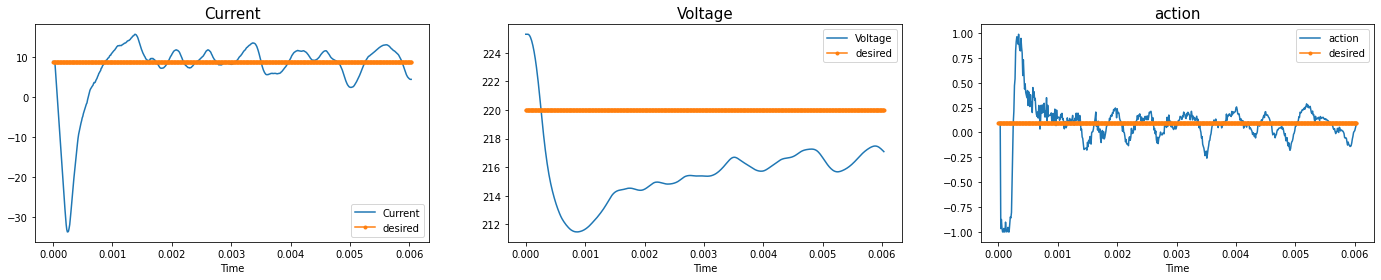

| Reward: -320.7881 | Episode: 110 | Qmax: -33.8270


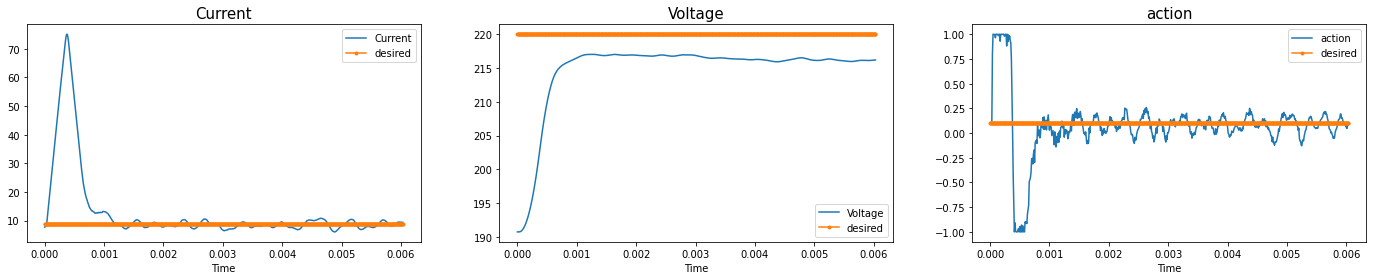

In [ ]:
env.reset()
replay_buffer = ReplayBuffer(111111, 123)
actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))
reward_result = np.zeros(2500)
paths, reward_result = train(env, test_env, args, actor, critic, actor_noise, reward_result, scaler, replay_buffer)

In [ ]:
env.action_trajectory

[[0.2650000000000001],
 [0.2650000000000001],
 [0.2650000000000001],
 [0.2650000000000001],
 [array([-0.981369], dtype=float32)],
 [array([-0.9879697], dtype=float32)],
 [array([-1.], dtype=float32)],
 [array([-0.97033024], dtype=float32)],
 [array([-0.99349254], dtype=float32)],
 [array([-0.9630597], dtype=float32)],
 [array([-0.9873775], dtype=float32)],
 [array([-0.9813], dtype=float32)],
 [array([-0.98285], dtype=float32)],
 [array([-0.99043477], dtype=float32)],
 [array([-0.98080593], dtype=float32)],
 [array([-0.9923077], dtype=float32)],
 [array([-0.98089767], dtype=float32)],
 [array([-0.97702], dtype=float32)],
 [array([-0.98161536], dtype=float32)],
 [array([-0.99125946], dtype=float32)],
 [array([-0.98332596], dtype=float32)],
 [array([-0.9800727], dtype=float32)],
 [array([-0.9832656], dtype=float32)],
 [array([-0.9735749], dtype=float32)],
 [array([-0.973456], dtype=float32)],
 [array([-0.9859123], dtype=float32)],
 [array([-0.9783775], dtype=float32)],
 [array([-0.9812569

In [ ]:
env.step(env.action_trajectory[4][0])

(array([-47.414402, 234.0236  ], dtype=float32),
 -0.16189460355928664,
 False,
 {})

In [ ]:
env.action_trajectory[4][0]

array([-0.981369], dtype=float32)

In [ ]:
np.array(critic.predict_target(s2_batch, actor.predict_target(s2_batch)))

array([[0.00156914],
       [0.00157229],
       [0.00156817]], dtype=float32)

In [ ]:
a = np.array([75.09], dtype="float32")
a

array([75.09], dtype=float32)